## this python script is used to extend the shoreline in the folder ECY_estimateed_shorelines

### shoreline in the folder ECY_estimateed_shorelines are missing some part of the shoreline, this script is used to extend the shoreline to the edge of the image

In [425]:
from shapely.geometry import Point, Polygon, LineString, MultiLineString,MultiPoint,MultiPolygon
from pyproj import Geod
import geojson
import copy
import pyproj

In [426]:
import numpy as np

In [427]:
import math

In [428]:
import geojson

In [415]:
with open('assets/ECY_estimated_shorelines/1700_Jun27.geojson') as f:
    gj_1700_jun = geojson.load(f)
for feature in gj_1700_jun['features']:
    print(feature['properties']['layer'])
#gj_1700_jun

layer1
layer3


In [417]:
with open('assets/ECY_estimated_shorelines/1702_Jun27.geojson') as f:
    gj_1702_jun = geojson.load(f)
binn=[]
for feature in gj_1702_jun['features']:
    binn.append(feature['properties']['layer'])

#find unique values


print(set(binn))

{'layer2', 'layer3', 'layer1'}


In [420]:
with open('assets/ECY_estimated_shorelines/1911_Jun28.geojson') as f:
    gj_1911_jun = geojson.load(f)
binn=[]
for feature in gj_1911_jun['features']:
    binn.append(feature['properties']['layer'])

#find unique values


print(set(binn))

{'layer2', 'layer1'}


### extend the 1701-1859 **coastside** shoreline to the south

In [429]:
#load 1700 survey geojson file
#import 1700 geojson file
with open('assets/shore_1700.geojson') as f:
    gj_1700 = geojson.load(f)
#print(gj)

In [430]:
#load 1860 survey geojson file
#import 1860 geojson file
with open('assets/shore_1860.geojson') as f:
    gj_1860 = geojson.load(f)
#print(gj)

In [431]:
geod = Geod(ellps='WGS84')   #the projection system is WGS84
f_azimuth, b_azimuth,_ = geod.inv(-124, 45, -124, 46)

In [433]:
b_azimuth

180.0

In [434]:
#function to get the distance between two points，the result is in km
#in km

def haversine_distance(lon1, lat1, lon2, lat2):
    
    #x_1,y_1=convert_line_cooridination_system_to_wgs([[lon1, lat1],[lon2, lat2]])

    #lon1=x_1[0]
    #lon2=y_1[0]
    #lat1=x_1[1]
    #lat2=y_1[1]

    # Earth's radius in kilometers
    R = 6371

    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Difference in latitudes and longitudes
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    # Haversine formula
    a = math.sin(delta_lat/2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon/2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c

    return distance


# Example usage
lat1 = 52.5200  # Latitude of first point
lon1 = 13.4050  # Longitude of first point
lat2 = 48.8566  # Latitude of second point
lon2 = 2.3522   # Longitude of second point

result = haversine_distance(lon1, lat1, lon2, lat2)
print(result)


877.4633259175432


In [462]:
haversine_distance(118.593596,24.934312, -122.310706, 47.655795)

9914.647209065628

In [435]:
#get the list of transect lines
#each transect line is a list of two points, the right point is each point in the 1700 shoreline, and then extend the line horizontally to the left

#empty list to store the x_values
x_values = []

#get the number of points in gj_1700
for i in range(len(gj_1700["features"][0]["geometry"]["coordinates"][0])):
    
    #x_value is the latitude of the horizontal transect lines
    x_values.append(gj_1700["features"][0]["geometry"]["coordinates"][0][i][1])

    #y_value is the longitude of the left end of transect lines
    y_value=-124.140016

    #zip the x and y values together
    points = zip([y_value]*len(x_values),x_values)
    points = list(points)
    #change the points to a list of lists
    points_left = [[point[0],point[1]] for point in points]

points_right = gj_1700["features"][0]["geometry"]["coordinates"][0]

line=list(zip(points_left,points_right))

#list of transects lines
list_of_transects=[list(t) for t in line]


In [436]:
list_of_transects

[[[-124.140016, 46.881191], [-124.11697, 46.881191]],
 [[-124.140016, 46.858835], [-124.110708, 46.858835]],
 [[-124.140016, 46.823382], [-124.097339, 46.823382]],
 [[-124.140016, 46.794212], [-124.090194, 46.794212]],
 [[-124.140016, 46.768967], [-124.085611, 46.768967]],
 [[-124.140016, 46.745573], [-124.085233, 46.745573]],
 [[-124.140016, 46.737395], [-124.079244, 46.737395]]]

In [56]:
list_of_transects[-1]

[[-124.140016, 46.737395], [-124.079244, 46.737395]]

In [437]:
#determine which line in the list of transects is the northernmost line
#the northernmost line is the line we use to find the intersection point between the two shorelines and the transect line. The bounded length is the length we want to offset the 1700 line
if list_of_transects[0][0][1] > list_of_transects[-1][0][1]:
    northmost_transect = list_of_transects[0]
else:
    northmost_transect = list_of_transects[-1]

#northmost_transect = [[-124.140016, 46.88], [-124.11697, 46.88]]
northmost_transect


[[-124.140016, 46.881191], [-124.11697, 46.881191]]

In [438]:
#this is the funtion to offset the point, with given distance and bearing

from geographiclib.geodesic import Geodesic

import math

#point in the format of [lon,lat]   d in meters, bearing in degrees
def offset_pt(point,d,bearing):
    # Define the point's coordinates (longitude, latitude)
    lon1, lat1 = point[0], point[1]

    # Define the distance to move the point (in meters) and the bearing (in degrees)
    distance = d  # in meters
    bearing = bearing  # 50 degrees

    # Calculate destination point
    geod = Geodesic.WGS84  # define the WGS84 ellipsoid

    dest = geod.Direct(lat1, lon1, bearing, distance)

    lon2, lat2 = dest['lon2'], dest['lat2']

    return [lon2,lat2]


In [112]:
with open('assets/shore_1700.geojson') as f:
    gj_1700 = geojson.load(f)
gj_1700

{"features": [{"geometry": {"coordinates": [[[-124.11697, 46.881191], [-124.110708, 46.858835], [-124.097339, 46.823382], [-124.090194, 46.794212], [-124.085611, 46.768967], [-124.085233, 46.745573], [-124.079244, 46.737395]]], "type": "MultiLineString"}, "properties": {}, "type": "Feature"}], "type": "FeatureCollection"}

In [440]:
#transect line is the horizontal line that goes through the southern most point of the 1860 shoreline
gj_1860["features"][0]["geometry"]["coordinates"][0]

[[-124.117626, 46.877113],
 [-124.117716, 46.877859],
 [-124.118055, 46.878537],
 [-124.118327, 46.879171],
 [-124.11853, 46.879736],
 [-124.118847, 46.880573],
 [-124.119186, 46.88141],
 [-124.119503, 46.88245],
 [-124.119684, 46.883332],
 [-124.119548, 46.884304],
 [-124.119706, 46.885051],
 [-124.119661, 46.886001],
 [-124.119751, 46.887018],
 [-124.119706, 46.887606],
 [-124.11939, 46.888262],
 [-124.119186, 46.889167],
 [-124.119209, 46.889687],
 [-124.118847, 46.890162],
 [-124.118824, 46.891225],
 [-124.118508, 46.891926],
 [-124.118168, 46.892944],
 [-124.117874, 46.894391],
 [-124.117445, 46.895409],
 [-124.116902, 46.897127],
 [-124.116088, 46.898303],
 [-124.115839, 46.899095],
 [-124.115126, 46.900499],
 [-124.114172, 46.9017],
 [-124.112971, 46.902937],
 [-124.111628, 46.903997],
 [-124.109897, 46.90488],
 [-124.108492, 46.905178],
 [-124.107246, 46.905552],
 [-124.106222, 46.905799],
 [-124.104843, 46.906046],
 [-124.103783, 46.906011],
 [-124.102653, 46.905834],
 [-124.1

In [442]:
len(gj_1860["features"][0]["geometry"]["coordinates"])

2

In [444]:
#get the southern most point of the 1860 shoreline

gj_1860["features"][0]["geometry"]["coordinates"][0][0]
southmost_lat=gj_1860["features"][0]["geometry"]["coordinates"][0][0][1]
southmost_lat

46.877113

In [445]:

#first we need the transect line
transect=LineString([[-125, southmost_lat], [-124, southmost_lat]])

#then we need the shoreline of 1700 and find the intersection point with the transect line
with open('assets/shore_1700.geojson') as f:
    gj_1700 = geojson.load(f)

#get the linestring of the gj_1700
shoreline_1700 = LineString(gj_1700['features'][0]['geometry']['coordinates'][0])

#find the intersection point
insct_pt_1700 = transect.intersection(shoreline_1700)

print("intersection between transects and 1700 sholine is: ", insct_pt_1700)

print(insct_pt_1700.x,insct_pt_1700.y)
print("shoreline_1700: ", shoreline_1700)

intersection between transects and 1700 sholine is:  POINT (-124.11582773680443 46.877113)
-124.11582773680443 46.877113
shoreline_1700:  LINESTRING (-124.11697 46.881191, -124.110708 46.858835, -124.097339 46.823382, -124.090194 46.794212, -124.085611 46.768967, -124.085233 46.745573, -124.079244 46.737395)


In [451]:
gj_1860["features"][0]["geometry"]["coordinates"][0][0]

#get the distance between the intersection with 1700 and the southernmost point of 1860
d = haversine_distance(insct_pt_1700.x,insct_pt_1700.y,gj_1860["features"][0]["geometry"]["coordinates"][0][0][0],gj_1860["features"][0]["geometry"]["coordinates"][0][0][1])

d

0.13668419234752718

In [453]:
#create a empty list to store the distance to move in each year
distance_to_move_since1700 = []

increment = d/160

for i in range(160):
    distance_to_move_since1700.append(increment*(i+1))

distance_to_move_since1700


[0.0008542762021720449,
 0.0017085524043440898,
 0.0025628286065161347,
 0.0034171048086881796,
 0.0042713810108602245,
 0.005125657213032269,
 0.005979933415204314,
 0.006834209617376359,
 0.007688485819548404,
 0.008542762021720449,
 0.009397038223892495,
 0.010251314426064539,
 0.011105590628236583,
 0.011959866830408629,
 0.012814143032580674,
 0.013668419234752718,
 0.014522695436924762,
 0.015376971639096808,
 0.016231247841268854,
 0.017085524043440898,
 0.017939800245612942,
 0.01879407644778499,
 0.019648352649957034,
 0.020502628852129078,
 0.02135690505430112,
 0.022211181256473166,
 0.023065457458645213,
 0.023919733660817257,
 0.0247740098629893,
 0.02562828606516135,
 0.026482562267333393,
 0.027336838469505437,
 0.02819111467167748,
 0.029045390873849525,
 0.029899667076021572,
 0.030753943278193616,
 0.031608219480365664,
 0.03246249568253771,
 0.03331677188470975,
 0.034171048086881796,
 0.03502532428905384,
 0.035879600491225884,
 0.03673387669339793,
 0.0375881528955

In [ ]:
haversine_distance(-124.140016, 46.88, -124.11697, 46.88)

In [ ]:

#an empty dictionary to store the extended lines of each year between 1701 and 1859
extended_lines={}

for i in range(1701,1860):
    
    """with open('assets/ECY_estimated_shorelines/'+str(i)+'.geojson') as f:
        gj = geojson.load(f)
    
    #first we need to find the intersection point between the northernmost transcets line and the shoreline of the year in the loop
    shoreline_current = LineString(gj['geometry']["coordinates"])
    insct_pt_current = transect.intersection(shoreline_current)

    #second we need to measure the distance to move
    #the distance is in kilometer (km)
    distance= haversine_distance(insct_pt_1700.x,insct_pt_1700.y,insct_pt_current.x,insct_pt_current.y)

    #third we need to move the points on 1700 line to the wast to the new location by the distance we just calculated
       """
        
    list_of_pts=[]
    for point in gj_1700['features'][0]['geometry']['coordinates'][0]:
        distance=distance_to_move_since1700[i-1701]
        new_point = offset_pt(point,distance*1000,270)                   #offest all points on the 1700 shoreline to the east by the distance we just calculated.
        list_of_pts.append(new_point)


    #finally, after all points have been offset, we need to put them in a dictionary
    extended_lines[str(i)]=list_of_pts

print(extended_lines)



In [456]:
len(extended_lines)

159

In [135]:
#test cell
# the line is extended from north to south, decreasing lat
extended_lines['1701']

[[-124.11698219154297, 46.88119099999935],
 [-124.1107201864819, 46.85883499999935],
 [-124.09735117846829, 46.823381999999356],
 [-124.09020617188627, 46.794211999999355],
 [-124.0856231661982, 46.76896699999936],
 [-124.08524516093406, 46.745572999999354],
 [-124.0792561590954, 46.73739499999935]]

In [458]:
#find if all of the extended_lines extend from the north to the south
i=0
for key in extended_lines.keys():
    if extended_lines[key][0][1] > extended_lines[key][1][1]:
        i=i+1

if i == len(extended_lines):
    print("all extended lines extend from north to south")

all extended lines extend from north to south


In [460]:
gj_1860["features"][0]["geometry"]["coordinates"][0][0]

[-124.117626, 46.877113]

In [461]:
point_1700_north=offset_pt(gj_1860["features"][0]["geometry"]["coordinates"][0][0],d*1000,90)

point_1700_north


[-124.11583295491661, 46.87711298595789]

In [464]:
tmp_points=[]
for i in range(160):
    distance=distance_to_move_since1700[i]
    point=offset_pt(point_1700_north,distance*1000,270)
    tmp_points.append(point)

len(tmp_points)

160

first point in tmp_points is 1701, and last point is 1860

In [465]:
tmp_points[-1]

[-124.11762599999953, 46.87711297191578]

In [459]:
#find if the original shorelins extend from the north to the south
k=0
for i in range(1701,1860):
    with open('assets/ECY_estimated_shorelines/'+str(i)+'.geojson') as f:
        gj = geojson.load(f)
    shoreline_current = gj['geometry']["coordinates"]
    if shoreline_current[0][1]<shoreline_current[1][1]:
        k=k+1
if k==len(extended_lines):
    print("all original shorelines extend from south to north")

all original shorelines extend from south to north


In [466]:
#for the extended lines, if the point is north of the southmost point of the original line, remove it. Because it should be south of the southmost point
for i in range(1701,1860):

    """with open('assets/ECY_estimated_shorelines/'+str(i)+'.geojson') as f:
        gj = geojson.load(f)"""
    #first find the southmost point of the original line
    ##because the original line is a list of points from south to north, the southmost point is the first point
    southmost_pt = tmp_points[i-1701]
    for pt in extended_lines[str(i)]:
        #remove the point if this point is north of the southmost point
        if pt[1] > southmost_pt[1]:
            extended_lines[str(i)].remove(pt)
        else:
            break
    #insert the southmost point to the beginning of the extended line
    extended_lines[str(i)].insert(0,southmost_pt)


    

In [467]:
#write the template for feature collection

outer_template={"type": "FeatureCollection","features":[]}

#write the template for feature

feature_template={"type": "Feature","properties":{},"geometry":{"type": "LineString"}}



In [468]:
import json

In [472]:
#rewrite the shoreline geojson file from 1701 to 1859
for i in range(1701,1860):
    # insert the original shoreline as layer one
    """with open('assets/ECY_estimated_shorelines/'+str(i)+'.geojson') as f:
        gj = geojson.load(f)"""
    #first we need to amend gj to make it conform to our desired structure
    #gj['properties']['layer']='layer1'
    #outer_template={"type": "FeatureCollection","features":[]}

    #feature_template={"type": "Feature","properties":{},"geometry":{"type": "LineString"}}
    outer_template={"type": "FeatureCollection","features":[]}
    tmp_outer=outer_template.copy()
    """
    if i == 1701:
        print(tmp_outer)
    tmp_outer['features'].append(gj)
"""

    #then we need to insert the extended line as layer two
    feature_template={"type": "Feature","properties":{},"geometry":{"type": "LineString"}}
    tmp_inner=feature_template.copy()
    tmp_inner['properties']['layer']='layer1'
    tmp_inner['geometry']["coordinates"]=extended_lines[str(i)]
    tmp_outer['features'].append(tmp_inner)

    """tmp=feature_template.copy()
    tmp['properties']['layer']='layer1'
    tmp['geometry']["coordinates"]=gj['geometry']['coordinates']
    tmp1=feature_template.copy()
    tmp1['properties']['layer']='layer2'
    tmp1['geometry']["coordinates"]=extended_lines[str(i)]

    #insert tmp and tmp1 to the outer_template
    outer_tmp_copy=outer_template.copy()
    outer_tmp_copy['features'].append(tmp)
    outer_tmp_copy['features'].append(tmp1)"""

    #print(outer_tmp_copy)

    #write the outer_tmp_copy to a new geojson file
    with open('assets/ECY_estimated_shorelines/Aug4/'+str(i)+'.geojson', 'w') as f:
        json.dump(tmp_outer, f)


In [473]:
with open('assets/ECY_estimated_shorelines/Aug4/1701.geojson') as f:
    gj_1701 = geojson.load(f)
gj_1701
#gj_1701["geometry"]["coordinates"]

{"features": [{"geometry": {"coordinates": [[-124.115844, 46.877113], [-124.110719, 46.858835], [-124.09735, 46.823382], [-124.090205, 46.794212], [-124.085622, 46.768967], [-124.085244, 46.745573], [-124.079255, 46.737395]], "type": "LineString"}, "properties": {"layer": "layer1"}, "type": "Feature"}], "type": "FeatureCollection"}

In [474]:
with open('assets/ECY_estimated_shorelines/Aug4/1791.geojson') as f:
    gj_1791 = geojson.load(f)
gj_1791

{"features": [{"geometry": {"coordinates": [[-124.116853, 46.877113], [-124.111727, 46.858835], [-124.098358, 46.823382], [-124.091212, 46.794212], [-124.086629, 46.768967], [-124.08625, 46.745573], [-124.080261, 46.737395]], "type": "LineString"}, "properties": {"layer": "layer1"}, "type": "Feature"}], "type": "FeatureCollection"}

## extend the 1701-1859 **oceanside** shoreline to the north, which is curved.

### this time, we do not start from the 1700. Instead, we start from the 1860, and offest the 1860 shoreline towards the land.

In [475]:
#preview of the 1860 geojson file
if len(gj_1860["features"])==1:
    print("the 1860 geojson file has only one feature")

the 1860 geojson file has only one feature


In [476]:
print("The 1860 original file is multiLineString, with {} lineString".format(len(gj_1860["features"][0]["geometry"]["coordinates"])))

The 1860 original file is multiLineString, with 2 lineString


In [ ]:
#a dictionary to store the extended curves between 1701 and 1859
extended_curves={}

In [477]:
#test cell
print(transect)

LINESTRING (-125 46.877113, -124 46.877113)


In [180]:
#test cell
gj_1860["features"][0]["geometry"]["coordinates"][0]

[[-124.117626, 46.877113],
 [-124.117716, 46.877859],
 [-124.118055, 46.878537],
 [-124.118327, 46.879171],
 [-124.11853, 46.879736],
 [-124.118847, 46.880573],
 [-124.119186, 46.88141],
 [-124.119503, 46.88245],
 [-124.119684, 46.883332],
 [-124.119548, 46.884304],
 [-124.119706, 46.885051],
 [-124.119661, 46.886001],
 [-124.119751, 46.887018],
 [-124.119706, 46.887606],
 [-124.11939, 46.888262],
 [-124.119186, 46.889167],
 [-124.119209, 46.889687],
 [-124.118847, 46.890162],
 [-124.118824, 46.891225],
 [-124.118508, 46.891926],
 [-124.118168, 46.892944],
 [-124.117874, 46.894391],
 [-124.117445, 46.895409],
 [-124.116902, 46.897127],
 [-124.116088, 46.898303],
 [-124.115839, 46.899095],
 [-124.115126, 46.900499],
 [-124.114172, 46.9017],
 [-124.112971, 46.902937],
 [-124.111628, 46.903997],
 [-124.109897, 46.90488],
 [-124.108492, 46.905178],
 [-124.107246, 46.905552],
 [-124.106222, 46.905799],
 [-124.104843, 46.906046],
 [-124.103783, 46.906011],
 [-124.102653, 46.905834],
 [-124.1

In [480]:
#the distance between 1860 shoreline and 1700 shoreline on transect

#first we need to find the intersection point between transect and the 1860 shoreline
insct_pt_1860 = transect.intersection(MultiLineString(gj_1860["features"][0]["geometry"]["coordinates"]))

print(insct_pt_1860)
#get the third point of the insct_pt_1860 multipoint

print(insct_pt_1860.geoms[2].x)
#get the distance  to move between 
distance_1860_1700=haversine_distance(insct_pt_1700.x,insct_pt_1700.y,insct_pt_1860.geoms[2].x,insct_pt_1860.geoms[2].y)
distance_1860_1700

MULTIPOINT (-124.09564945856353 46.877113, -124.10140380882353 46.877113, -124.117626 46.877113, -124.09042525531915 46.877113)
-124.10140380882353


0.13668419234752718

In [484]:
distance_to_move_since1700[-1]==d

True

In [485]:
#distance_to_move_since1700.append(distance_1860_1700)
distance_from_1860_back=list(reversed(distance_to_move_since1700))
distance_from_1860_back=[distance_1860_1700- i for i in distance_from_1860_back]

distance_from_1860_back.append(distance_1860_1700)   #the distance to move from 1860 to 1700 is the distance between 1860 and 1700

In [486]:
distance_from_1860_back

[0.0,
 0.000854276202172044,
 0.001708552404344088,
 0.002562828606516132,
 0.003417104808688176,
 0.00427138101086022,
 0.005125657213032264,
 0.005979933415204308,
 0.006834209617376352,
 0.007688485819548396,
 0.00854276202172044,
 0.009397038223892484,
 0.010251314426064528,
 0.011105590628236572,
 0.01195986683040863,
 0.012814143032580674,
 0.013668419234752718,
 0.014522695436924762,
 0.015376971639096806,
 0.01623124784126885,
 0.017085524043440894,
 0.01793980024561294,
 0.018794076447784983,
 0.019648352649957027,
 0.020502628852129084,
 0.02135690505430113,
 0.022211181256473173,
 0.023065457458645217,
 0.02391973366081726,
 0.024774009862989305,
 0.02562828606516135,
 0.026482562267333393,
 0.027336838469505437,
 0.02819111467167748,
 0.029045390873849525,
 0.02989966707602157,
 0.030753943278193613,
 0.03160821948036566,
 0.0324624956825377,
 0.033316771884709745,
 0.03417104808688179,
 0.03502532428905385,
 0.03587960049122589,
 0.036733876693397935,
 0.03758815289556998,

In [489]:
#remove the first element of distance_from_1860_back
distance_from_1860_back.pop(0)

0.0

In [490]:
len(distance_from_1860_back)

160

In [491]:
#a dictionary to store the extended curves between 1701 and 1859
extended_curves={}

for i in range(1859,1699,-1):
    #a list to store the offset points of the year
    offset_points=[]
    for linestring in gj_1860["features"][0]["geometry"]["coordinates"]:    #add [0] to exclude grass island
        offset_points_linestring=[]
        #each j associated with a point in the line
        for j in range(0,len(linestring)-4,3):       #set the step to 3 to make the line lower in resolution
            #get the azimuth of the line
            geo=Geod(ellps='WGS84')
            f_azimuth, b_azimuth,_ = geo.inv(linestring[j][0], linestring[j][1], linestring[j+3][0], linestring[j+3][1])
            azimuth=90+f_azimuth
            if azimuth>360:
                azimuth=azimuth-360
            point=offset_pt(linestring[j],distance_from_1860_back[1859-i]*1000,azimuth)    #offset_pt(point,d,bearing)
            offset_points_linestring.append(point)
        offset_points.append(offset_points_linestring)
    extended_curves[str(i)]=offset_points


In [493]:
#preview the extended curves
extended_curves["1701"]

[[[-124.11589085083986, 46.877390882136844],
  [-124.11660371048639, 46.87948182466947],
  [-124.11741053322328, 46.881514390753566],
  [-124.11776825982602, 46.8843665602088],
  [-124.11799710295517, 46.886801251131615],
  [-124.11741658505356, 46.88902071069185],
  [-124.11707825029292, 46.89097881866773],
  [-124.11617294695158, 46.894026082430024],
  [-124.11442538616573, 46.89786242176673],
  [-124.11286098293334, 46.90087209263979],
  [-124.10928589858345, 46.90373219444197],
  [-124.1061964526913, 46.90457729270042],
  [-124.10348801043246, 46.90475447604969],
  [-124.10084707804567, 46.90387090708237],
  [-124.09867397097028, 46.90231450370166],
  [-124.09757151392728, 46.902872482806984],
  [-124.0959168354278, 46.90262556546456],
  [-124.09665548223144, 46.90295439825298],
  [-124.09780836561812, 46.903625083712335],
  [-124.09865811384513, 46.90406898906023],
  [-124.10012668985904, 46.9049744494094],
  [-124.10184378718212, 46.90593326030173],
  [-124.10428375274738, 46.906

In [521]:

#write the template for feature collection

outer_template={"type": "FeatureCollection","features":[]}

#write the template for feature

feature_template={"type": "Feature","properties":{},"geometry":{"type": "LineString"}}



In [269]:
#test cell
extended_curves.keys()

dict_keys(['1859', '1858', '1857', '1856', '1855', '1854', '1853', '1852', '1851', '1850', '1849', '1848', '1847', '1846', '1845', '1844', '1843', '1842', '1841', '1840', '1839', '1838', '1837', '1836', '1835', '1834', '1833', '1832', '1831', '1830', '1829', '1828', '1827', '1826', '1825', '1824', '1823', '1822', '1821', '1820', '1819', '1818', '1817', '1816', '1815', '1814', '1813', '1812', '1811', '1810', '1809', '1808', '1807', '1806', '1805', '1804', '1803', '1802', '1801', '1800', '1799', '1798', '1797', '1796', '1795', '1794', '1793', '1792', '1791', '1790', '1789', '1788', '1787', '1786', '1785', '1784', '1783', '1782', '1781', '1780', '1779', '1778', '1777', '1776', '1775', '1774', '1773', '1772', '1771', '1770', '1769', '1768', '1767', '1766', '1765', '1764', '1763', '1762', '1761', '1760', '1759', '1758', '1757', '1756', '1755', '1754', '1753', '1752', '1751', '1750', '1749', '1748', '1747', '1746', '1745', '1744', '1743', '1742', '1741', '1740', '1739', '1738', '1737', '1736

In [494]:
#rewrite the shoreline geojson file from 1701 to 1859
for i in range(1701,1860):
    # insert the original shoreline as layer one
    with open('assets/ECY_estimated_shorelines/Aug4/'+str(i)+'.geojson') as f:
        gj = geojson.load(f)
    
    feature_template={"type": "Feature","properties":{},"geometry":{"type": "LineString"}}
    tmp_inner=feature_template.copy()
    #if i == 1701:
    #    print(tmp_outer)
    #tmp_inner['features'].append(gj)
    tmp_inner['geometry']['type']='MultiLineString'
    tmp_inner['properties']['layer']='layer3'
    tmp_inner['geometry']["coordinates"]=extended_curves[str(i)]

    gj['features'].append(tmp_inner)


    #then we need to insert the extended line as layer two
    

    #print(outer_tmp_copy)

    #write the outer_tmp_copy to a new geojson file
    with open('assets/ECY_estimated_shorelines/Aug4/'+str(i)+'.geojson', 'w') as f:
        json.dump(gj, f)

In [495]:
#rewrite the shoreline geojson file of 1700
with open('assets/shore_1700.geojson') as f:
    gj_1700 = geojson.load(f)
gj_1700["features"][0]["properties"]["layer"]="layer1"

feature_template={"type": "Feature","properties":{},"geometry":{"type": "LineString"}}
tmp_inner=feature_template.copy()
tmp_inner['geometry']['type']='MultiLineString'
tmp_inner['properties']['layer']='layer3'
tmp_inner['geometry']["coordinates"]=extended_curves["1700"]

gj_1700['features'].append(tmp_inner)


#then we need to insert the extended line as layer two


#print(outer_tmp_copy)

#write the outer_tmp_copy to a new geojson file
with open('assets/ECY_estimated_shorelines/Aug4/1700.geojson', 'w') as f:
    json.dump(gj_1700, f)

In [497]:
distance_1860_1700==d

True

In [498]:
#rewrite the shoreline geojson file of 1860
with open('assets/shore_1700.geojson') as f:
    gj_1700 = geojson.load(f)

#empty list to store the offset points
offset_points_1700_1860=[]
for point in gj_1700['features'][0]['geometry']['coordinates'][0]:
    n_point=offset_pt(point,distance_1860_1700*1000,270)   #offset_pt(point,d,bearing)

    offset_points_1700_1860.append(n_point)

In [499]:
offset_points_1700_1860

[[-124.1187631809381, 46.8811909859559],
 [-124.11250043653422, 46.85883498596681],
 [-124.09913025785947, 46.823381985984085],
 [-124.09198428974948, 46.79421198599828],
 [-124.08740045312591, 46.768966986010554],
 [-124.08702167885471, 46.74557298602192],
 [-124.08103240841632, 46.73739498602589]]

In [500]:
gj_1860["features"][0]["geometry"]["coordinates"][0][0]

[-124.117626, 46.877113]

In [501]:
#remove the first point of the offset_points_1700_1860
offset_points_1700_1860.pop(0)
offset_points_1700_1860

[[-124.11250043653422, 46.85883498596681],
 [-124.09913025785947, 46.823381985984085],
 [-124.09198428974948, 46.79421198599828],
 [-124.08740045312591, 46.768966986010554],
 [-124.08702167885471, 46.74557298602192],
 [-124.08103240841632, 46.73739498602589]]

In [502]:
offset_points_1700_1860.insert(0,[-124.117626, 46.877113])
offset_points_1700_1860

[[-124.117626, 46.877113],
 [-124.11250043653422, 46.85883498596681],
 [-124.09913025785947, 46.823381985984085],
 [-124.09198428974948, 46.79421198599828],
 [-124.08740045312591, 46.768966986010554],
 [-124.08702167885471, 46.74557298602192],
 [-124.08103240841632, 46.73739498602589]]

In [504]:
with open('assets/shore_1860.geojson') as f:
    gj_1860 = geojson.load(f)

#layer 1 is the original shoreline
gj_1860["features"][0]["properties"]["layer"]="layer1"

feature_template={"type": "Feature","properties":{},"geometry":{"type": "LineString"}}

tmp_inner=feature_template.copy()

#tmp_inner['geometry']['type']='MultiLineString'

tmp_inner['properties']['layer']='layer2'

tmp_inner['geometry']["coordinates"] = offset_points_1700_1860

gj_1860['features'].append(tmp_inner)


#then we need to insert the extended line as layer two


#print(outer_tmp_copy)

#write the outer_tmp_copy to a new geojson file
with open('assets/ECY_estimated_shorelines/Aug4/1860.geojson', 'w') as f:
    json.dump(gj_1860, f)



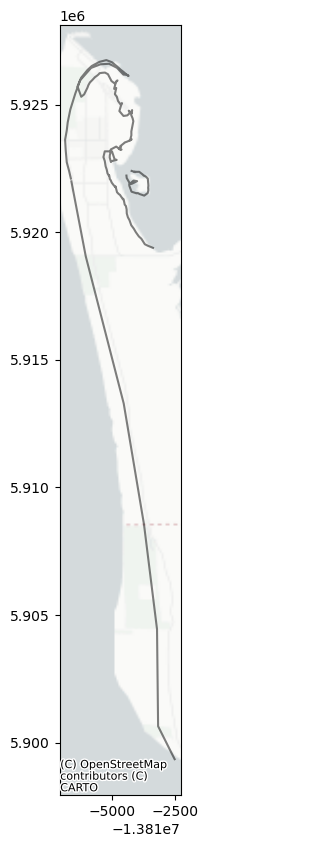

In [507]:
#preview of the 1801_jul23 geojson file
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Load a GeoDataFrame from a GeoJSON file
#gdf = gpd.read_file('assets/ECY_estimated_shorelines/1801_Jul23.geojson')
#load 1860 shoreline
gdf = gpd.read_file('assets/ECY_estimated_shorelines/Aug4/'+str(1760)+'.geojson')


# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)
gdf = gdf.to_crs(epsg=3857)

# Create a plot
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

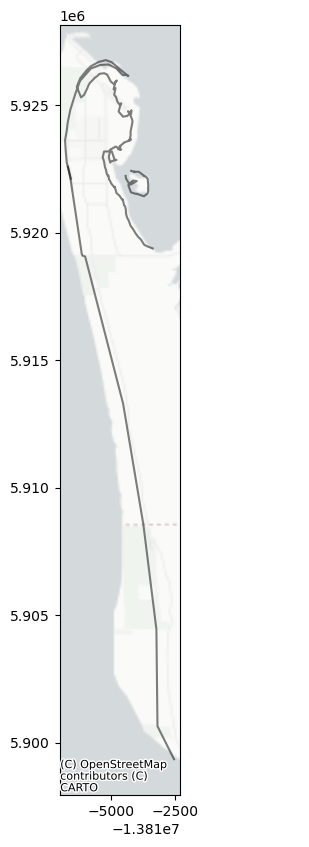

In [380]:
gdf = gpd.read_file('assets/ECY_estimated_shorelines/'+str(1760)+'_Jun27.geojson')


# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)
gdf = gdf.to_crs(epsg=3857)

# Create a plot
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

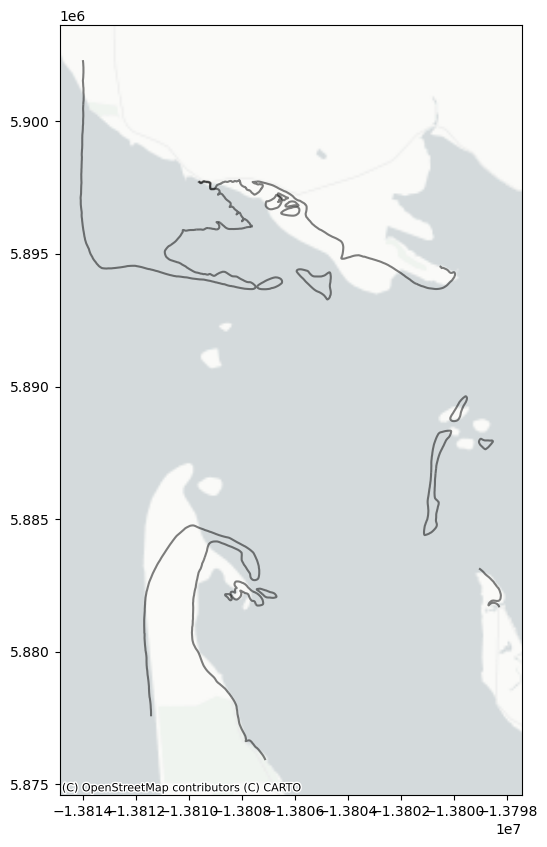

In [289]:
gdf = gpd.read_file('assets/f_1911_coastline_bay.geojson')


# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)
gdf = gdf.to_crs(epsg=3857)

# Create a plot
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

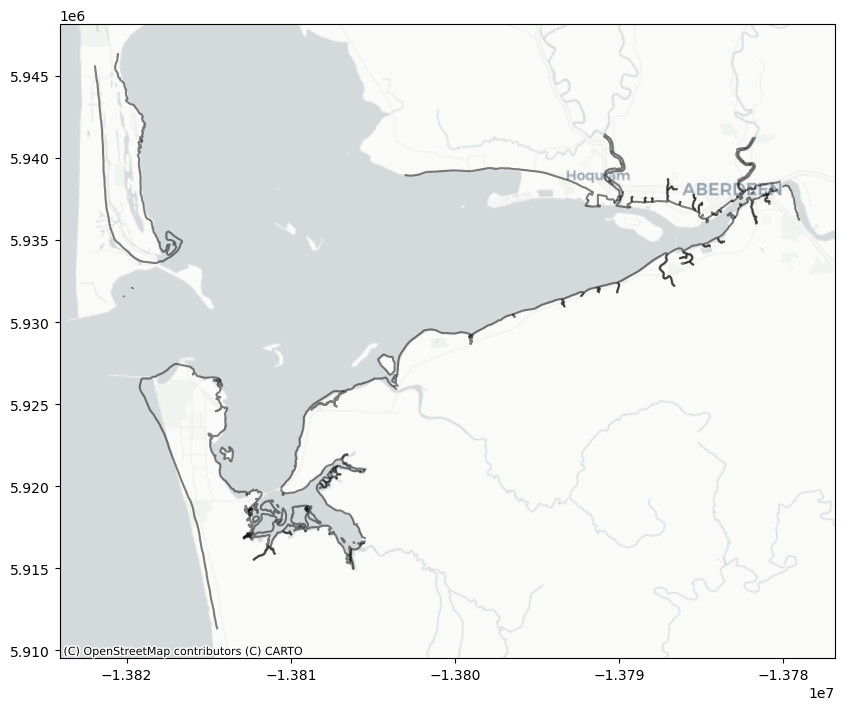

In [293]:
gdf = gpd.read_file('assets/shore_1911.geojson')


# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)
gdf = gdf.to_crs(epsg=3857)

# Create a plot
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

In [91]:
l_3=LineString([[-124.116608, 46.879856],[-124.116742, 46.880331]])
print(transect.intersection(l_3))#function to convert cooridination system from EPSG: 32149 to WGS84
##point = [lon,lat]
def convert_line_cooridination_system_to_wgs(line):
    # Define the source and target coordinate systems
    src_crs = pyproj.CRS.from_epsg(32149)
    tgt_crs = pyproj.CRS.from_epsg(4326)

    # Create a transformer object
    transformer = pyproj.Transformer.from_crs(src_crs, tgt_crs, always_xy=True)

    #an empty list to store the converted points
    converted_points = []
    
    #iterate over every point in the line
    for i in range(len(line)):
        # Convert a single point
        x_1, y_1 = transformer.transform(line[i][0], line[i][1])
        converted_points.append([x_1,y_1])

    return converted_points


POINT (-124.1166486231579 46.88)


## Now plot the line from 1860 to 1911

In [508]:
#import two 1911 shoreline files
with open('assets/f_1911_coastline_bay.geojson') as f:
    gj_1911_bay = geojson.load(f)
#gj_1911_bay["features"]

#find the northernmost point of the 1911 shoreline

#a temporary variable to store the altitude of the northernmost point
tmp_altitude=0

for feature in gj_1911_bay["features"]:
    for linestring in feature["geometry"]["coordinates"]:
        #the northmost point is either the first or the last point of the linestring
        alt_1=linestring[0]
        alt_2=linestring[-1]
        if alt_1[1]>alt_2[1]:
            t=alt_1
        else:
            t=alt_2
        if t[1]>tmp_altitude:
            tmp_altitude=t[1]
            northmost_point=t

print(northmost_point)

[-124.093264, 46.7558]


In [509]:
print("the northmost point of the 1911 bay shoreline is: "+str(northmost_point))

the northmost point of the 1911 bay shoreline is: [-124.093264, 46.7558]


In [510]:
#then find the southernmost point of the 1911 shoreline on the north side of the willapa bay
with open('assets/shore_1911.geojson') as f:
    gj_1911 = geojson.load(f)

tmp_altitude=90

for feature in gj_1911["features"]:
    for linestring in feature["geometry"]["coordinates"]:
        #the northmost point is either the first or the last point of the linestring
        alt_1=linestring[0]
        alt_2=linestring[-1]
        if alt_1[1]<alt_2[1]:
            t=alt_1
        else:
            t=alt_2
        if t[1]<tmp_altitude:
            tmp_altitude=t[1]
            southmost_point=t

print(southmost_point)

[-124.097544, 46.811028]


In [511]:
print("the southmost point of the 1911 bay shoreline is: "+str(southmost_point))

the southmost point of the 1911 bay shoreline is: [-124.097544, 46.811028]


In [512]:
#append gj_1911_bay to gj_1911
gj_1911["features"]=gj_1911["features"]+gj_1911_bay["features"]

In [513]:
#add the layer type to each feature in gj_1911
for feature in gj_1911["features"]:
    feature["properties"]["layer"]="layer1"

In [514]:
#connect southmost point and northmost point and append it to gj_1911
gj_1911["features"].append({"type": "Feature","properties":{'layer':'layer2'},"geometry":{"coordinates":[southmost_point,northmost_point],"type": "LineString"}})

In [515]:
#write the gj_1911 to a new geojson file
with open('assets/ECY_estimated_shorelines/Aug4/1911.geojson', 'w') as f:
    json.dump(gj_1911, f)


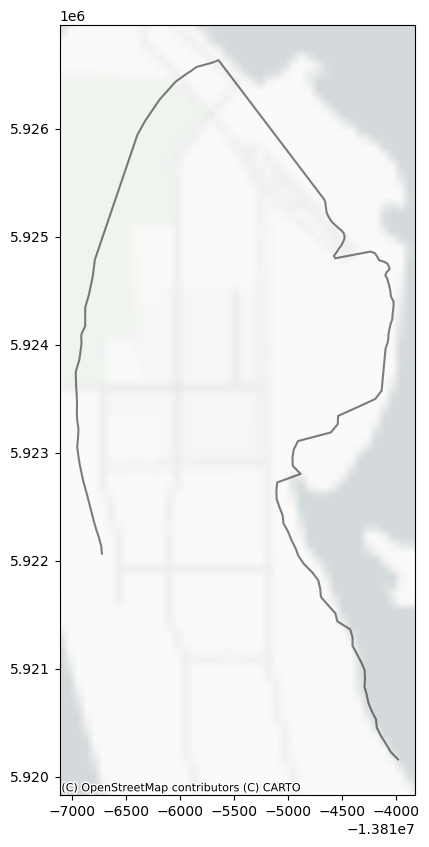

In [524]:
gdf = gpd.read_file('assets/ECY_estimated_shorelines/1861.geojson')


# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)
gdf = gdf.to_crs(epsg=3857)

# Create a plot
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

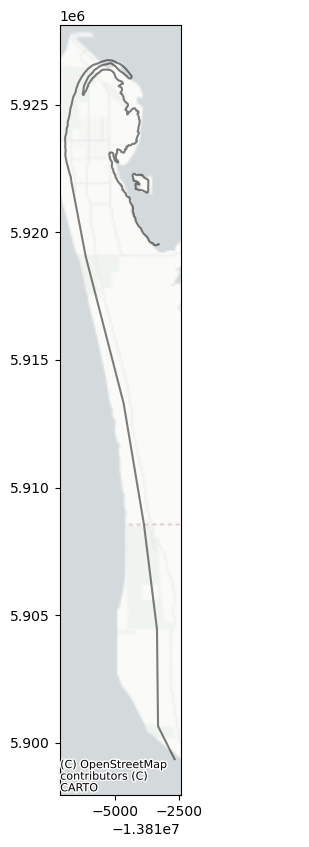

In [525]:
gdf = gpd.read_file('assets/ECY_estimated_shorelines/Aug4/1860.geojson')


# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)
gdf = gdf.to_crs(epsg=3857)

# Create a plot
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

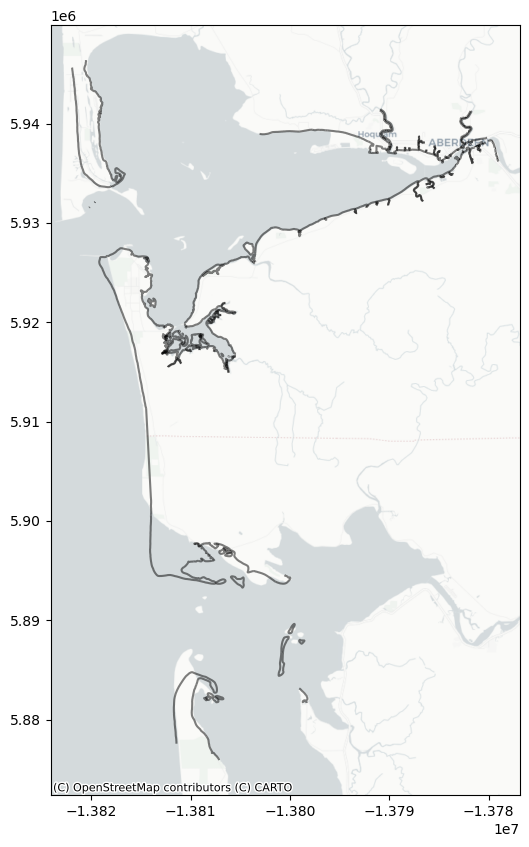

In [516]:
gdf = gpd.read_file('assets/ECY_estimated_shorelines/Aug4/1911.geojson')


# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)
gdf = gdf.to_crs(epsg=3857)

# Create a plot
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

In [517]:
#preview list of transects
list_of_transects

[[[-124.140016, 46.881191], [-124.11697, 46.881191]],
 [[-124.140016, 46.858835], [-124.110708, 46.858835]],
 [[-124.140016, 46.823382], [-124.097339, 46.823382]],
 [[-124.140016, 46.794212], [-124.090194, 46.794212]],
 [[-124.140016, 46.768967], [-124.085611, 46.768967]],
 [[-124.140016, 46.745573], [-124.085233, 46.745573]],
 [[-124.140016, 46.737395], [-124.079244, 46.737395]]]

In [518]:
#convert each transect to line string object
list_of_transects_str=[]
for i in range(len(list_of_transects)):
    list_of_transects_str.append(LineString(list_of_transects[i]))

In [519]:
#preview list of transects in string format
list_of_transects_str

[<LINESTRING (-124.14 46.881, -124.117 46.881)>,
 <LINESTRING (-124.14 46.859, -124.111 46.859)>,
 <LINESTRING (-124.14 46.823, -124.097 46.823)>,
 <LINESTRING (-124.14 46.794, -124.09 46.794)>,
 <LINESTRING (-124.14 46.769, -124.086 46.769)>,
 <LINESTRING (-124.14 46.746, -124.085 46.746)>,
 <LINESTRING (-124.14 46.737, -124.079 46.737)>]

In [522]:
outer_template

{'type': 'FeatureCollection', 'features': []}

In [523]:
#convert the file to a geojson object that are consistant with the outer_template
for year in range(1861,1911):
    with open('assets/ECY_estimated_shorelines/'+str(year)+'.geojson') as f:
        gj = geojson.load(f)
        gj['properties']['layer']='layer1'
        gj={'type': 'FeatureCollection', 'features': [gj]}

    #write gj to a new geojson file
    with open('assets/ECY_estimated_shorelines/Aug4/'+str(year)+'.geojson', 'w') as f:
        json.dump(gj, f)

In [526]:
#get the southmost point of the sea side shoreline from 1861 to 1910
dict_of_southmost_points={}
for year in range(1861,1911):
    with open('assets/ECY_estimated_shorelines/Aug4/'+str(year)+'.geojson') as f:
        gj = geojson.load(f)
    for feature in gj["features"]:
        southmost_pt=feature['geometry']['coordinates'][0]
        dict_of_southmost_points[str(year)]=southmost_pt
   

    


In [527]:
#preview of the southmost points
dict_of_southmost_points

{'1861': [-124.117739, 46.877225],
 '1862': [-124.117838, 46.87721],
 '1863': [-124.117936, 46.877196],
 '1864': [-124.118034, 46.877182],
 '1865': [-124.118132, 46.877168],
 '1866': [-124.11823, 46.877154],
 '1867': [-124.118329, 46.87714],
 '1868': [-124.118427, 46.877126],
 '1869': [-124.118525, 46.877112],
 '1870': [-124.118623, 46.877098],
 '1871': [-124.118721, 46.877083],
 '1872': [-124.11882, 46.877069],
 '1873': [-124.118918, 46.877055],
 '1874': [-124.119016, 46.877041],
 '1875': [-124.119114, 46.877027],
 '1876': [-124.119213, 46.877013],
 '1877': [-124.119311, 46.876999],
 '1878': [-124.119409, 46.876985],
 '1879': [-124.119507, 46.876971],
 '1880': [-124.119605, 46.876956],
 '1881': [-124.119704, 46.876942],
 '1882': [-124.119802, 46.876928],
 '1883': [-124.1199, 46.876914],
 '1884': [-124.119998, 46.8769],
 '1885': [-124.120096, 46.876886],
 '1886': [-124.120195, 46.876872],
 '1887': [-124.120293, 46.876858],
 '1888': [-124.120391, 46.876844],
 '1889': [-124.120489, 46.87

In [528]:
#find the intersection of the transect from southmost point to the 1911 shorline towards sea side
transect_1860_1911={}
for year in range(1861,1911):
    alt_south=dict_of_southmost_points[str(year)][1]
    east_end=[-125.0,alt_south]
    transect_1860_1911[str(year)]=LineString([east_end,dict_of_southmost_points[str(year)]])

#preview the transect from southmost point to the 1911 shorline towards sea side
transect_1860_1911


{'1861': <LINESTRING (-125 46.877, -124.118 46.877)>,
 '1862': <LINESTRING (-125 46.877, -124.118 46.877)>,
 '1863': <LINESTRING (-125 46.877, -124.118 46.877)>,
 '1864': <LINESTRING (-125 46.877, -124.118 46.877)>,
 '1865': <LINESTRING (-125 46.877, -124.118 46.877)>,
 '1866': <LINESTRING (-125 46.877, -124.118 46.877)>,
 '1867': <LINESTRING (-125 46.877, -124.118 46.877)>,
 '1868': <LINESTRING (-125 46.877, -124.118 46.877)>,
 '1869': <LINESTRING (-125 46.877, -124.119 46.877)>,
 '1870': <LINESTRING (-125 46.877, -124.119 46.877)>,
 '1871': <LINESTRING (-125 46.877, -124.119 46.877)>,
 '1872': <LINESTRING (-125 46.877, -124.119 46.877)>,
 '1873': <LINESTRING (-125 46.877, -124.119 46.877)>,
 '1874': <LINESTRING (-125 46.877, -124.119 46.877)>,
 '1875': <LINESTRING (-125 46.877, -124.119 46.877)>,
 '1876': <LINESTRING (-125 46.877, -124.119 46.877)>,
 '1877': <LINESTRING (-125 46.877, -124.119 46.877)>,
 '1878': <LINESTRING (-125 46.877, -124.119 46.877)>,
 '1879': <LINESTRING (-125 4

In [529]:
#find the intersection of the transect and 1911 shoreline
gdf_1911 = gpd.read_file('assets/ECY_estimated_shorelines/Aug4/1911.geojson')

insct_pt_on_1911={}
for year in range(1861,1911):
    line = transect_1860_1911[str(year)]

    intersecting_lines = gdf_1911[gdf_1911['geometry'].apply(lambda x: line.intersects(x))]
    intersection_points = intersecting_lines['geometry'].apply(lambda x: line.intersection(x))

    insct_pt=[intersection_points.x,intersection_points.y]
    insct_pt_on_1911[str(year)]=insct_pt


#for year in range(1861,1911):


In [530]:
print(Point(insct_pt_on_1911["1861"]))

POINT (-124.12298387709497 46.877225)


In [531]:
dist_1860_1911={}
for year in range(1861,1911):
    dist_1860_1911[str(year)]=haversine_distance(dict_of_southmost_points[str(year)][0],dict_of_southmost_points[str(year)][1],insct_pt_on_1911[str(year)][0],insct_pt_on_1911[str(year)][1])

In [532]:
dist_1860_1911

{'1861': 0.3986570458716626,
 '1862': 0.39039197363219674,
 '1863': 0.38228251211919856,
 '1864': 0.37417304637047033,
 '1865': 0.36606357639181913,
 '1866': 0.35795410218131607,
 '1867': 0.3497686147740977,
 '1868': 0.34165913207813997,
 '1869': 0.3335496451522802,
 '1870': 0.3254401539945893,
 '1871': 0.3172834720887299,
 '1872': 0.3090979632384994,
 '1873': 0.3009884592020691,
 '1874': 0.29287895093189475,
 '1875': 0.28485062619966023,
 '1876': 0.2769492576066686,
 '1877': 0.2691238940570457,
 '1878': 0.26129852642004925,
 '1879': 0.25347315470342013,
 '1880': 0.24562088790767236,
 '1881': 0.23771949862584835,
 '1882': 0.22989411448219257,
 '1883': 0.2220687262569892,
 '1884': 0.21424333394830922,
 '1885': 0.20641793755615712,
 '1886': 0.19851652773795736,
 '1887': 0.19069112315904377,
 '1888': 0.18286571449667252,
 '1889': 0.1750403017508484,
 '1890': 0.1671879923974577,
 '1891': 0.15928656188486578,
 '1892': 0.15146113671796163,
 '1893': 0.1436357074656898,
 '1894': 0.135810274129

In [533]:
list_of_transects_str

[<LINESTRING (-124.14 46.881, -124.117 46.881)>,
 <LINESTRING (-124.14 46.859, -124.111 46.859)>,
 <LINESTRING (-124.14 46.823, -124.097 46.823)>,
 <LINESTRING (-124.14 46.794, -124.09 46.794)>,
 <LINESTRING (-124.14 46.769, -124.086 46.769)>,
 <LINESTRING (-124.14 46.746, -124.085 46.746)>,
 <LINESTRING (-124.14 46.737, -124.079 46.737)>]

In [534]:
#get the intersection of the transect and the 1911 shoreline
list_of_intersection_points=[]
gdf_1911 = gpd.read_file('assets/ECY_estimated_shorelines/Aug4/1911.geojson')
for i in range(len(list_of_transects_str)):
    line = list_of_transects_str[i]

    intersecting_lines = gdf_1911[gdf_1911['geometry'].apply(lambda x: line.intersects(x))]
    intersection_points = intersecting_lines['geometry'].apply(lambda x: line.intersection(x))

    insct_pt=[intersection_points.x,intersection_points.y]
    list_of_intersection_points.append(insct_pt)

In [535]:
list_of_intersection_points

[[17   -124.124943
  dtype: float64,
  17    46.881191
  dtype: float64],
 [17   -124.112089
  dtype: float64,
  17    46.858835
  dtype: float64],
 [17   -124.101192
  dtype: float64,
  17    46.823382
  dtype: float64],
 [708   -124.096241
  dtype: float64,
  708    46.794212
  dtype: float64],
 [708   -124.094284
  dtype: float64,
  708    46.768967
  dtype: float64],
 [676   -124.093114
  dtype: float64,
  676    46.745573
  dtype: float64],
 [677   -124.093472
  dtype: float64,
  677    46.737395
  dtype: float64]]

In [536]:
#test cell
list_of_intersection_points[0][0].item()

-124.1249425261959

In [537]:
#offset the intersection points to the land side
dict_offset_intersection_points={}
for year in range (1910,1860,-1):
    list_of_interpolated_points=[]
    for point in list_of_intersection_points:
        new_point=offset_pt([point[0].item(),point[1].item()],dist_1860_1911[str(year)]*1000,90)   #offset_pt(point,d,bearing)
        list_of_interpolated_points.append(new_point)
    dict_offset_intersection_points[str(year)]=list_of_interpolated_points

In [538]:
dict_offset_intersection_points

{'1910': [[-124.1248377204069, 46.88119099995202],
  [-124.1119841241544, 46.85883499995206],
  [-124.10108688615436, 46.823381999952126],
  [-124.09613617495404, 46.794211999952175],
  [-124.09417981405993, 46.76896699995221],
  [-124.09300909962005, 46.745572999952245],
  [-124.09336735064278, 46.73739499995226]],
 '1909': [[-124.12473166396683, 46.8811909998058],
  [-124.11187811174159, 46.85883499980595],
  [-124.10098094345344, 46.8233819998062],
  [-124.0960302895113, 46.79421199980639],
  [-124.09407397809872, 46.76896699980656],
  [-124.09290330945257, 46.74557299980672],
  [-124.09326157647018, 46.73739499980677]],
 '1908': [[-124.1246266047662, 46.881190999564076],
  [-124.11177309615422, 46.85883499956442],
  [-124.10087599692248, 46.82338199956496],
  [-124.09592539970015, 46.7942119995654],
  [-124.0939691373038, 46.76896699956578],
  [-124.0927985140208, 46.745572999566136],
  [-124.09315679688291, 46.73739499956625]],
 '1907': [[-124.12452102168419, 46.88119099922402],
 

In [539]:
#test cell
with open('assets/ECY_estimated_shorelines/Aug4/'+str(year)+'.geojson') as f:
    gj = geojson.load(f)
gj

{"features": [{"geometry": {"coordinates": [[-124.117739, 46.877225], [-124.117801, 46.87771], [-124.117985, 46.878177], [-124.118209, 46.878639], [-124.118409, 46.879104], [-124.118582, 46.879572], [-124.118758, 46.880041], [-124.118936, 46.880509], [-124.119123, 46.880976], [-124.119308, 46.881443], [-124.119454, 46.881916], [-124.119601, 46.882389], [-124.119707, 46.882868], [-124.119797, 46.883348], [-124.119733, 46.883851], [-124.119692, 46.884351], [-124.119795, 46.88483], [-124.119829, 46.885319], [-124.119813, 46.885815], [-124.11984, 46.886305], [-124.11989, 46.886792], [-124.119919, 46.887542], [-124.119889, 46.887692], [-124.119824, 46.887838], [-124.119759, 46.887984], [-124.119693, 46.888129], [-124.119627, 46.888275], [-124.119593, 46.888425], [-124.119563, 46.888575], [-124.119534, 46.888726], [-124.119504, 46.888876], [-124.119474, 46.889027], [-124.119443, 46.889177], [-124.119446, 46.889332], [-124.119455, 46.889488], [-124.119464, 46.889644], [-124.11942, 46.889793],

In [540]:

for year in range(1861,1911):
    with open('assets/ECY_estimated_shorelines/Aug4/'+str(year)+'.geojson') as f:
        gj = geojson.load(f)
    feature_template={"type": "Feature","properties":{},"geometry":{"type": "LineString"}}
    feature_template["properties"]["layer"]="layer2"
    feature_template["geometry"]["coordinates"]=dict_offset_intersection_points[str(year)]
    gj["features"].append(feature_template)

    with open('assets/ECY_estimated_shorelines/Aug4/'+str(year)+'.geojson', 'w') as f:
        json.dump(gj, f)

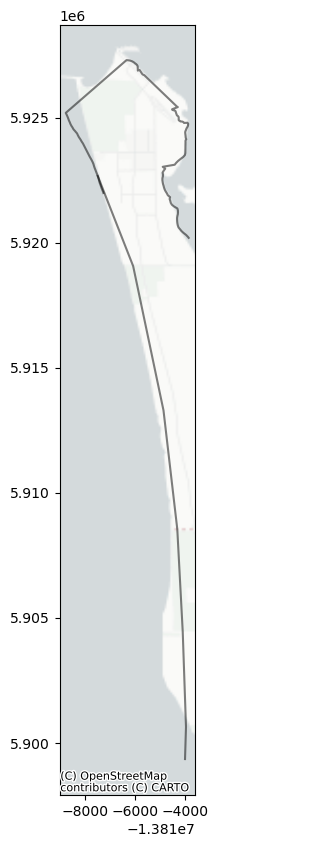

In [541]:
#preview the 1862 shoreline
gdf = gpd.read_file('assets/ECY_estimated_shorelines/Aug4/1910.geojson')


# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)
gdf = gdf.to_crs(epsg=3857)

# Create a plot
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

### Plot the willapa bay

In [724]:
#get the southernmost point in each year
def southern_1860_1911(year):
    #open the file
    file_direction='assets/ECY_estimated_shorelines/Aug4/'+str(year)+'.geojson'
    with open(file_direction) as f:
        gj=geojson.load(f)
    #empty variable to store the southernmost latitude
    tmp_south=90
    for feature in gj["features"]:
        line=feature["geometry"]["coordinates"]
        for point in line:
            latitude=point[1]
            if latitude < tmp_south:
                tmp_south=latitude

    return tmp_south


    

In [725]:
southern_1860_1911(1861)

46.737395

In [726]:
with open('assets/ECY_estimated_shorelines/Aug4/1860.geojson') as f:
        gj_1860=geojson.load(f)

with open('assets/ECY_estimated_shorelines/Aug4/1911.geojson') as f:
        gj_1911=geojson.load(f)

In [ ]:
#find the distance to move from 1911 back to 1860

#find the intersection between  
def distance_from1860_to_1911(year):
    south_lat=southern_1860_1911(year)
    transect=LineString([[-124.2,south_lat],[-124,south_lat]])
    #first find out which linestring in 1860 intersects with transects
    for f in gj_1911['features']:
    geometries = f['geometry']
    if geometries['type'] == 'MultiLineString':
        multi_line = MultiLineString(geometry['coordinates'])

        # Iterate through the LineString geometries within the MultiLineString
        for line_string_coords in multi_line:
            line_string = LineString(line_string_coords)

            # Find the intersection between the LineString and the provided LineString
            intersection = line.intersection(line_string)
            if not intersection.is_empty:
                print("Intersection found:", intersection)
    intersecting_lines = gdf_1911[gdf_1911['geometry'].apply(lambda x: line.intersects(x))]
    intersection_points = intersecting_lines['geometry'].apply(lambda x: transect.intersection(x))
    

# plot the shoreline from 1912 to 1926

In [574]:
#create a bounding box for the map
minx, miny, maxx, maxy = -124.176174, 46.689985, -123.908069, 46.917250  # these are just example coordinates


In [576]:
#import the 1911 shoreline
gdf_1911 = gpd.read_file('assets/ECY_estimated_shorelines/Aug4/1911.geojson')

In [577]:
gdf_1911=gdf_1911.cx[minx:maxx, miny:maxy]
gdf_1911

,FEATURE_ID,FEATURE,SOURCE_ID,DATA_SOURC,SRC_DATE,HOR_ACC,INFORM,RESOLUTION,ATTRIBUTE,CLASS,F_CODE,EX_METH,EXTRACT_TE,layer,geometry
0,946684.0,15.0,T03044,P,19090101,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,M,P,layer1,"MULTILINESTRING ((-124.02782 46.90018, -124.02..."
1,946685.0,26.0,T03044,P,19090101,0,None,0.0,Undetermined.Approximate,SHORELINE,None,M,P,layer1,"MULTILINESTRING ((-124.02703 46.90027, -124.02..."
2,946686.0,15.0,T03044,P,19090101,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,M,P,layer1,"MULTILINESTRING ((-124.02668 46.90046, -124.02..."
3,946266.0,15.0,T03044,P,19090101,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,M,P,layer1,"MULTILINESTRING ((-124.00882 46.91098, -124.00..."
12,946267.0,15.0,T03044,P,19090101,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,M,P,layer1,"MULTILINESTRING ((-124.09340 46.87673, -124.09..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,949584.0,26.0,T03224,P,19110101,0,None,0.0,Undetermined.Approximate,SHORELINE,None,M,P,layer1,"MULTILINESTRING ((-124.04714 46.71752, -124.04..."
703,949585.0,26.0,T03224,P,19110101,0,None,0.0,Undetermined.Approximate,SHORELINE,None,M,P,layer1,"MULTILINESTRING ((-124.04670 46.71801, -124.04..."
704,949587.0,26.0,T03224,P,19110101,0,None,0.0,Undetermined.Approximate,SHORELINE,None,M,P,layer1,"MULTILINESTRING ((-124.03810 46.71697, -124.03..."
705,949588.0,26.0,T03224,P,19110101,0,None,0.0,Undetermined.Approximate,SHORELINE,None,M,P,layer1,"MULTILINESTRING ((-124.04088 46.72065, -124.04..."


In [578]:
#import 1922 bay side shoreline
gdf_1922 = gpd.read_file('assets/f_1922_coastline_bay.geojson')
gdf_1922=gdf_1922.cx[minx:maxx, miny:maxy]
gdf_1922

,FEATURE_ID,FEATURE,SOURCE_ID,DATA_SOURC,SRC_DATE,HOR_ACC,INFORM,RESOLUTION,ATTRIBUTE,CLASS,F_CODE,EX_METH,EXTRACT_TE,geometry
0,950634.0,15.0,T03921,P,19220101,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,M,P,"MULTILINESTRING ((-123.99678 46.71696, -123.99..."
6,943937.0,15.0,T03921,P,19220101,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,M,P,"MULTILINESTRING ((-124.03747 46.71862, -124.03..."
7,943940.0,15.0,T03921,P,19220101,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,M,P,"MULTILINESTRING ((-123.97004 46.70711, -123.97..."
8,950631.0,20.0,T03921,P,19220101,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,"MULTILINESTRING ((-124.09183 46.74958, -124.09..."
9,951115.0,20.0,T03921,P,19220101,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,"MULTILINESTRING ((-124.05978 46.71011, -124.05..."
10,951116.0,20.0,T03921,P,19220101,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,"MULTILINESTRING ((-124.03880 46.70722, -124.03..."
11,951117.0,20.0,T03921,P,19220101,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,"MULTILINESTRING ((-124.02984 46.70486, -124.03..."
12,951118.0,20.0,T03921,P,19220101,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,"MULTILINESTRING ((-124.00353 46.70285, -124.00..."
13,951119.0,20.0,T03921,P,19220101,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,"MULTILINESTRING ((-124.02100 46.72088, -124.02..."
17,951123.0,20.0,T03921,P,19220101,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,"MULTILINESTRING ((-123.97022 46.73766, -123.97..."


In [584]:
#import 1926 coastline
gdf_1926 = gpd.read_file('assets/f_1926_coastline.geojson')

In [585]:
gdf_1926=gdf_1926.cx[minx:maxx, miny:maxy]
gdf_1926

,FEATURE_ID,FEATURE,SOURCE_ID,DATA_SOURC,SRC_DATE,HOR_ACC,INFORM,RESOLUTION,ATTRIBUTE,CLASS,F_CODE,EX_METH,EXTRACT_TE,geometry
11,912432.0,20.0,T04253,P,19260809,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,"MULTILINESTRING ((-124.01992 46.72163, -124.01..."
12,912428.0,26.0,T04253,P,19260809,0,None,0.0,Undetermined.Approximate,SHORELINE,None,M,P,"MULTILINESTRING ((-123.96684 46.70547, -123.96..."
13,912429.0,20.0,T04253,P,19260809,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,"MULTILINESTRING ((-123.96684 46.70547, -123.96..."
14,912430.0,20.0,T04253,P,19260809,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,"MULTILINESTRING ((-124.01706 46.70870, -124.01..."
15,912431.0,20.0,T04253,P,19260809,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,"MULTILINESTRING ((-124.01216 46.70680, -124.01..."
16,912433.0,20.0,T04253,P,19260809,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,"MULTILINESTRING ((-124.02485 46.72030, -124.02..."
17,912434.0,20.0,T04253,P,19260809,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,"MULTILINESTRING ((-124.09255 46.72443, -124.09..."
18,912435.0,15.0,T04253,P,19260809,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,M,P,"MULTILINESTRING ((-124.06213 46.71142, -124.06..."
19,912436.0,20.0,T04253,P,19260809,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,"MULTILINESTRING ((-124.05111 46.71653, -124.04..."
20,912437.0,15.0,T04253,P,19260809,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,M,P,"MULTILINESTRING ((-124.05164 46.72751, -124.05..."


In [586]:
#import the 1926 shoreline from WA ECY
gdf_1926_ecy = gpd.read_file('assets/ECY_historical_shorelines_epsg32149/1926.geojson')
gdf_1926_ecy=gdf_1926_ecy.cx[minx:maxx, miny:maxy]
gdf_1926_ecy

,id,YEAR,MONTH,Shape_Leng,geometry
0,0,1926,8,579.295047,"LINESTRING (-124.09337 46.89019, -124.09343 46..."
1,1,1926,8,762.883965,"LINESTRING (-124.13219 46.90506, -124.14213 46..."
2,2,1926,8,188.089538,"LINESTRING (-124.09949 46.90245, -124.09957 46..."
28,28,1926,8,3836.721912,"LINESTRING (-123.99290 46.70639, -123.99280 46..."
29,29,1926,8,161.670896,"LINESTRING (-124.09337 46.89019, -124.09333 46..."
30,30,1926,8,1633.191424,"LINESTRING (-124.09634 46.89262, -124.09712 46..."
31,31,1926,8,4818.943484,"LINESTRING (-124.10229 46.90403, -124.10286 46..."
32,32,1926,8,686.978283,"LINESTRING (-124.09337 46.89019, -124.08877 46..."
49,49,1926,8,7970.567350,"LINESTRING (-123.97196 46.70698, -123.97111 46..."
50,50,1926,8,4758.583501,"LINESTRING (-124.04150 46.72820, -124.04162 46..."


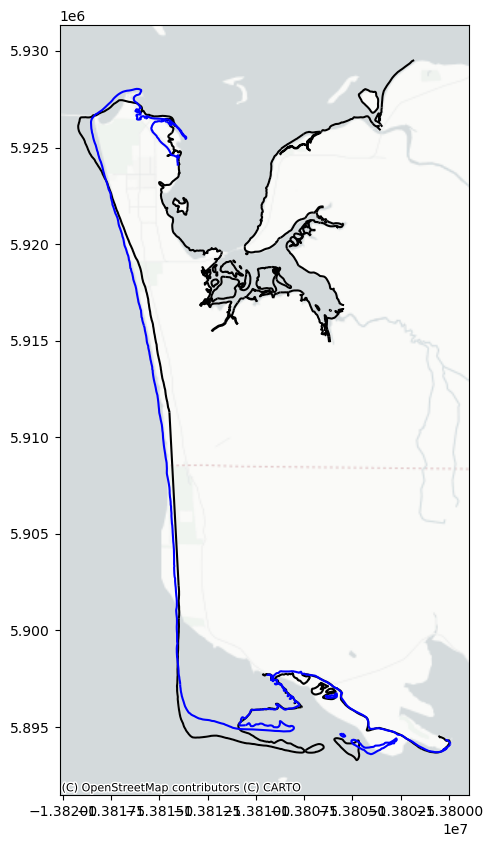

In [589]:
# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)
gdf_1911 = gdf_1911.to_crs(epsg=3857)
gdf_1922 = gdf_1922.to_crs(epsg=3857)
gdf_1926 = gdf_1926.to_crs(epsg=3857)
gdf_1926_ecy = gdf_1926_ecy.to_crs(epsg=3857)

# assuming gdf1 and gdf2 are your GeoDataFrames
fig, ax = plt.subplots(figsize = (10,10))

# plot the base map
base = gdf_1911.plot(ax=ax, color='white', edgecolor='black')

gdf_1911.plot(ax=base, marker='o', color='black', markersize=5)


# plot the first GeoDataFrame
#gdf_1922.plot(ax=base, marker='o', color='red', markersize=5)

# plot the second GeoDataFrame
gdf_1926.plot(ax=base, marker='o', color='blue', markersize=5)

#gdf_1926_ecy.plot(ax=base, marker='o', color='green', markersize=5)

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

plot the willapa bay first

In [729]:
#read 1911 and 1926 file with geopandas
gdf_1926 = gpd.read_file('assets/ECY_historical_shorelines_epsg32149/1926.geojson')
gdf_1911 = gpd.read_file('assets/ECY_estimated_shorelines/Aug4/1911.geojson')

In [732]:

from shapely.geometry import MultiPoint


In [736]:
gdf_1911

,FEATURE_ID,FEATURE,SOURCE_ID,DATA_SOURC,SRC_DATE,HOR_ACC,INFORM,RESOLUTION,ATTRIBUTE,CLASS,F_CODE,EX_METH,EXTRACT_TE,layer,geometry
0,946684.0,15.0,T03044,P,19090101,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,M,P,layer1,"MULTILINESTRING ((-124.02782 46.90018, -124.02..."
1,946685.0,26.0,T03044,P,19090101,0,None,0.0,Undetermined.Approximate,SHORELINE,None,M,P,layer1,"MULTILINESTRING ((-124.02703 46.90027, -124.02..."
2,946686.0,15.0,T03044,P,19090101,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,M,P,layer1,"MULTILINESTRING ((-124.02668 46.90046, -124.02..."
3,946266.0,15.0,T03044,P,19090101,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,M,P,layer1,"MULTILINESTRING ((-124.00882 46.91098, -124.00..."
4,946688.0,20.0,T03044,P,19090101,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,layer1,"MULTILINESTRING ((-124.16458 47.02184, -124.16..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,949587.0,26.0,T03224,P,19110101,0,None,0.0,Undetermined.Approximate,SHORELINE,None,M,P,layer1,"MULTILINESTRING ((-124.03810 46.71697, -124.03..."
705,949588.0,26.0,T03224,P,19110101,0,None,0.0,Undetermined.Approximate,SHORELINE,None,M,P,layer1,"MULTILINESTRING ((-124.04088 46.72065, -124.04..."
706,950107.0,26.0,T03224,P,19110101,0,None,0.0,Undetermined.Approximate,SHORELINE,None,M,P,layer1,"MULTILINESTRING ((-123.97364 46.66091, -123.97..."
707,950109.0,26.0,T03224,P,19110101,0,None,0.0,Undetermined.Approximate,SHORELINE,None,M,P,layer1,"MULTILINESTRING ((-123.95227 46.62869, -123.95..."


In [740]:

# Function to get individual linestrings from a geometry, whether it's a LineString or MultiLineString
def get_linestrings(geometry):
    if isinstance(geometry, LineString):
        return [geometry]
    elif isinstance(geometry, MultiLineString):
        return list(geometry.geoms)
    else:
        raise TypeError('Geometry must be a LineString or MultiLineString')


def find_itsc_two_geojson(gdf_1,gdf_2):
    # Collect all intersection points
    intersections = []

    # Iterate over geometries in the first file
    for geometry1 in gdf_1.geometry:
        linestrings1 = get_linestrings(geometry1)

        # Iterate over geometries in the second file
        for geometry2 in gdf_2.geometry:
            linestrings2 = get_linestrings(geometry2)

            # Compare all combinations of linestrings
            for line1 in linestrings1:
                for line2 in linestrings2:
                    intersection = line1.intersection(line2)
                    if intersection.is_empty:
                        continue
                    #if intersection.geom_type == 'Point':
                    else:
                        intersections.append(intersection)

    # Create a GeoDataFrame from the intersections and save to a new GeoJSON file
    intersections_gdf = gpd.GeoDataFrame(geometry=intersections)
    #intersections_gdf.to_file('intersections.geojson', driver='GeoJSON')
    return intersections_gdf


find_itsc_two_geojson(gdf_1911,gdf_1926)


,geometry
0,POINT (-124.12538 46.94957)
1,POINT (-124.13351 46.90517)
2,POINT (-124.12666 46.88434)
3,POINT (-124.12409 46.95112)
4,POINT (-124.09304 46.89020)
5,"MULTIPOINT (-124.09688 46.90305, -124.09720 46..."
6,"MULTIPOINT (-124.09329 46.89160, -124.09305 46..."
7,"MULTIPOINT (-124.09662 46.89310, -124.09668 46..."
8,"MULTIPOINT (-124.11340 46.90945, -124.12913 46..."
9,"MULTIPOINT (-124.09547 46.90263, -124.09513 46..."


In [741]:
# Function to get individual points from a geometry, whether it's a Point or MultiPoint
def get_points(geometry):
    if isinstance(geometry, Point):
        return [geometry]
    elif isinstance(geometry, MultiPoint):
        return list(geometry.geoms)
    else:
        raise TypeError('Geometry must be a LineString or MultiLineString')

p=find_itsc_two_geojson(gdf_1911,gdf_1926).geometry[0]
for geometry in find_itsc_two_geojson(gdf_1911,gdf_1926).geometry:
    for point in get_points(geometry):
        if point.x < -124.07 and point.y<p.y:
            p=point

print(p)



POINT (-124.09358953869004 46.733252766225945)


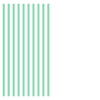

In [756]:
def transect_gen (start_longitude,end_longitude,number_of_parts):
    interval = (start_longitude - end_longitude) / number_of_parts

    # Generate the divisions
    divisions = [start_longitude - i * interval for i in range(number_of_parts + 1)]

    coordinates_south = list(zip(divisions, [46.657113] * len(divisions)))

    coordinates_north = list(zip(divisions, [46.757113] * len(divisions)))

    ts=list(zip(coordinates_south,coordinates_north))
    ts.pop()

    ts=MultiLineString(ts)

    return ts

#example
transect_gen(-124.04,-124.09358953869004,10)



In [757]:
for t in transect_gen(-124.04,-124.09358953869004,10).geoms:
    print(t)


LINESTRING (-124.04 46.657113, -124.04 46.757113)
LINESTRING (-124.04535895386901 46.657113, -124.04535895386901 46.757113)
LINESTRING (-124.05071790773802 46.657113, -124.05071790773802 46.757113)
LINESTRING (-124.05607686160701 46.657113, -124.05607686160701 46.757113)
LINESTRING (-124.06143581547602 46.657113, -124.06143581547602 46.757113)
LINESTRING (-124.06679476934502 46.657113, -124.06679476934502 46.757113)
LINESTRING (-124.07215372321403 46.657113, -124.07215372321403 46.757113)
LINESTRING (-124.07751267708304 46.657113, -124.07751267708304 46.757113)
LINESTRING (-124.08287163095203 46.657113, -124.08287163095203 46.757113)
LINESTRING (-124.08823058482103 46.657113, -124.08823058482103 46.757113)


In [758]:
def find_intersection_bay(gdf_1):
    #create an empty list to store the saved intersect points for each transect
    final_intersections=[]
    for t in transect_gen(-124.04,-124.09358953869004,10).geoms:
        #for each transects, create an empty list to store the intersections 
        geom_list=[]
        for geometry1 in gdf_1.geometry:
            linestrings1 = get_linestrings(geometry1)
            for line1 in linestrings1:

                if t.intersects(line1):

                    intersection=t.intersection(line1)

                    geom_list.append(intersection)

        # Flatten the MultiPoints into individual Points
        all_points = []
        for geom in geom_list:
            if isinstance(geom, MultiPoint):
                all_points += list(geom.geoms)
            else:
                all_points.append(geom)

        #if only one point, then append this point to the final
        if len(all_points)==1:
            final_intersections.append(all_points)
        else:
            two_southernmost_points = sorted(all_points, key=lambda point: point.y)[:2]
            final_intersections.append(two_southernmost_points)

    return final_intersections

find_intersection_bay(gdf_1911)

    

[[<POINT (-124.04 46.703)>, <POINT (-124.04 46.705)>],
 [<POINT (-124.045 46.704)>, <POINT (-124.045 46.707)>],
 [<POINT (-124.051 46.705)>, <POINT (-124.051 46.706)>],
 [<POINT (-124.056 46.705)>, <POINT (-124.056 46.707)>],
 [<POINT (-124.061 46.706)>, <POINT (-124.061 46.709)>],
 [<POINT (-124.067 46.707)>],
 [<POINT (-124.072 46.708)>],
 [<POINT (-124.078 46.708)>],
 [<POINT (-124.083 46.708)>],
 [<POINT (-124.088 46.708)>]]

then get the intersection point from the 1926 file

In [764]:
find_intersection_bay(gdf_1926)

[[<POINT (-124.04 46.71)>, <POINT (-124.04 46.711)>],
 [<POINT (-124.045 46.709)>, <POINT (-124.045 46.712)>],
 [<POINT (-124.051 46.709)>, <POINT (-124.051 46.711)>],
 [<POINT (-124.056 46.71)>, <POINT (-124.056 46.711)>],
 [<POINT (-124.061 46.71)>, <POINT (-124.061 46.711)>],
 [<POINT (-124.067 46.71)>],
 [<POINT (-124.072 46.711)>],
 [<POINT (-124.078 46.712)>],
 [<POINT (-124.083 46.713)>],
 [<POINT (-124.088 46.715)>]]

In [769]:
d=find_intersection_bay(gdf_1926)

In [775]:
def flatten_find_intersection_bay(list_of_pts):
    c=0
    for i in list_of_pts:
        if len(i)==2:
            c=c+1
    
    empty_list=[]
    for i in range(c-1,-1,-1):
        empty_list.append(list_of_pts[i][1])
    for i in range(len(list_of_pts)):
        empty_list.append(list_of_pts[i][0])
    return empty_list

In [780]:
flat_1926=flatten_find_intersection_bay(d)
flat_1926

[<POINT (-124.061 46.711)>,
 <POINT (-124.056 46.711)>,
 <POINT (-124.051 46.711)>,
 <POINT (-124.045 46.712)>,
 <POINT (-124.04 46.711)>,
 <POINT (-124.04 46.71)>,
 <POINT (-124.045 46.709)>,
 <POINT (-124.051 46.709)>,
 <POINT (-124.056 46.71)>,
 <POINT (-124.061 46.71)>,
 <POINT (-124.067 46.71)>,
 <POINT (-124.072 46.711)>,
 <POINT (-124.078 46.712)>,
 <POINT (-124.083 46.713)>,
 <POINT (-124.088 46.715)>]

In [777]:
d_1911=find_intersection_bay(gdf_1911)

In [779]:
flat_1911=flatten_find_intersection_bay(d_1911)
flat_1911

[<POINT (-124.061 46.709)>,
 <POINT (-124.056 46.707)>,
 <POINT (-124.051 46.706)>,
 <POINT (-124.045 46.707)>,
 <POINT (-124.04 46.705)>,
 <POINT (-124.04 46.703)>,
 <POINT (-124.045 46.704)>,
 <POINT (-124.051 46.705)>,
 <POINT (-124.056 46.705)>,
 <POINT (-124.061 46.706)>,
 <POINT (-124.067 46.707)>,
 <POINT (-124.072 46.708)>,
 <POINT (-124.078 46.708)>,
 <POINT (-124.083 46.708)>,
 <POINT (-124.088 46.708)>]

In [790]:
for geometry2 in gdf_1911.geometry:
    linestrings2 = get_linestrings(geometry2)
    for line in linestrings2:
        intersection=line.intersection(LineString([(-124.08,46.712),(-124.0345,46.712)]))

        if intersection.is_empty:
            continue
        else:
            print(intersection)



POINT (-124.06502575510204 46.712)


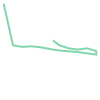

In [797]:
def interpolation(year,start_year,end_year,flat_1,flat_2):
    line=[[-124.06502575510204, 46.712]]  #this is the start point of the line
    for i,v in enumerate(flat_1):
        distance=haversine_distance(v.x,v.y,flat_2[i].x,flat_2[i].y)/(start_year-end_year)*(year-start_year)
        n_point=offset_pt([v.x,v.y],distance*1000,180)
        line.append(n_point)
    line.append([-124.09358953869004, 46.733252766225945])   #this is the end point of the line
    line=LineString(line)

    return line

#example of 1913
interpolation(1913,1911,1926,flat_1911,flat_1926)


In [794]:
print(flat_1911[0])

POINT (-124.06143581547602 46.70891138799941)


In [798]:
print(interpolation(1913,1911,1926,flat_1911,flat_1926))

LINESTRING (-124.06502575510204 46.712, -124.06143581547602 46.709216132480556, -124.05607686160701 46.70745982617769, -124.05071790773802 46.706711015718035, -124.04535895386901 46.707420813888945, -124.04 46.70584814189226, -124.04 46.703809897697646, -124.04535895386901 46.70450134545436, -124.05071790773802 46.70526654667924, -124.05607686160701 46.705703548791405, -124.06143581547602 46.70614991803472, -124.06679476934502 46.70701589830491, -124.07215372321403 46.70802680450518, -124.07751267708304 46.70861517263627, -124.08287163095203 46.70826485352658, -124.08823058482103 46.70921901556006, -124.09358953869004 46.733252766225945)


In [813]:
#this is the function to keep features out of the polygon
def handle_geometry(geometry):
    polygon=Polygon([(-124.10358, 46.733252766225945),(-124.08, 46.733252766225945),(-124.08,46.712),(-124.0345,46.712),(-124.0345,46.69),(-124.10358,46.69)])
    if geometry.intersects(polygon):  # If the geometry intersects the polygon
        return geometry.difference(polygon) # Return the part of the geometry outside the polygon
    elif not polygon.contains(geometry):  # If the geometry is completely outside the polygon
        return geometry
    else:
        return None # Return None if the geometry is completely inside the polygon
    
gdf_tmp = gdf_1911['geometry'].apply(handle_geometry)

gdf_tmp


0      MULTILINESTRING ((-124.02782 46.90018, -124.02...
1      MULTILINESTRING ((-124.02703 46.90027, -124.02...
2      MULTILINESTRING ((-124.02668 46.90046, -124.02...
3      MULTILINESTRING ((-124.00882 46.91098, -124.00...
4      MULTILINESTRING ((-124.16458 47.02184, -124.16...
                             ...                        
704    MULTILINESTRING ((-124.03810 46.71697, -124.03...
705    MULTILINESTRING ((-124.04088 46.72065, -124.04...
706    MULTILINESTRING ((-123.97364 46.66091, -123.97...
707    MULTILINESTRING ((-123.95227 46.62869, -123.95...
708    LINESTRING (-124.09754 46.81103, -124.09326 46...
Name: geometry, Length: 709, dtype: geometry

/usr/local/Caskroom/miniconda/base/envs/geo/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

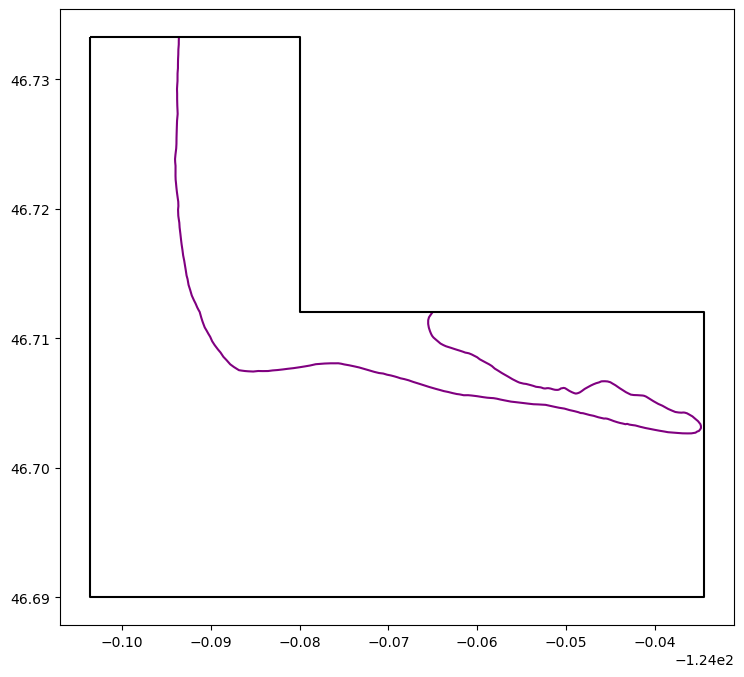

In [765]:
polygon=Polygon([(-124.10358, 46.733252766225945),(-124.08, 46.733252766225945),(-124.08,46.712),(-124.0345,46.712),(-124.0345,46.69),(-124.10358,46.69)])
gdf_1911_clipped = gdf_1911.clip(polygon)
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=gdf_1911.crs)

fig, ax = plt.subplots(figsize=(12, 8))
gdf_1911_clipped.plot(ax=ax, color="purple")
poly_gdf.boundary.plot(ax=ax, color="black")


In [814]:
#preview
gdf_tmp

0      MULTILINESTRING ((-124.02782 46.90018, -124.02...
1      MULTILINESTRING ((-124.02703 46.90027, -124.02...
2      MULTILINESTRING ((-124.02668 46.90046, -124.02...
3      MULTILINESTRING ((-124.00882 46.91098, -124.00...
4      MULTILINESTRING ((-124.16458 47.02184, -124.16...
                             ...                        
704    MULTILINESTRING ((-124.03810 46.71697, -124.03...
705    MULTILINESTRING ((-124.04088 46.72065, -124.04...
706    MULTILINESTRING ((-123.97364 46.66091, -123.97...
707    MULTILINESTRING ((-123.95227 46.62869, -123.95...
708    LINESTRING (-124.09754 46.81103, -124.09326 46...
Name: geometry, Length: 709, dtype: geometry

In [803]:
type(gdf_tmp)

geopandas.geoseries.GeoSeries

In [815]:
print(gdf_tmp.crs)

epsg:4326


In [816]:
gdf_1911_unchanged = gpd.GeoDataFrame({'geometry': gdf_tmp})

gdf_1911_unchanged

,geometry
0,"MULTILINESTRING ((-124.02782 46.90018, -124.02..."
1,"MULTILINESTRING ((-124.02703 46.90027, -124.02..."
2,"MULTILINESTRING ((-124.02668 46.90046, -124.02..."
3,"MULTILINESTRING ((-124.00882 46.91098, -124.00..."
4,"MULTILINESTRING ((-124.16458 47.02184, -124.16..."
...,...
704,"MULTILINESTRING ((-124.03810 46.71697, -124.03..."
705,"MULTILINESTRING ((-124.04088 46.72065, -124.04..."
706,"MULTILINESTRING ((-123.97364 46.66091, -123.97..."
707,"MULTILINESTRING ((-123.95227 46.62869, -123.95..."


In [766]:
gdf_1911_clipped

,FEATURE_ID,FEATURE,SOURCE_ID,DATA_SOURC,SRC_DATE,HOR_ACC,INFORM,RESOLUTION,ATTRIBUTE,CLASS,F_CODE,EX_METH,EXTRACT_TE,layer,geometry
677,949582.0,20.0,T03224,P,19110101,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,layer1,"LINESTRING (-124.09359 46.73325, -124.09361 46..."


In [819]:
gpd_1913=gpd.GeoDataFrame({'geometry': [interpolation(1913,1911,1926,flat_1911,flat_1926)]})

gpd_1913 = pd.concat([gpd_1913, gdf_1911_unchanged], ignore_index=True)

gpd_1913

/usr/local/Caskroom/miniconda/base/envs/geo/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


,geometry
0,"LINESTRING (-124.06503 46.71200, -124.06144 46..."
1,"MULTILINESTRING ((-124.02782 46.90018, -124.02..."
2,"MULTILINESTRING ((-124.02703 46.90027, -124.02..."
3,"MULTILINESTRING ((-124.02668 46.90046, -124.02..."
4,"MULTILINESTRING ((-124.00882 46.91098, -124.00..."
...,...
705,"MULTILINESTRING ((-124.03810 46.71697, -124.03..."
706,"MULTILINESTRING ((-124.04088 46.72065, -124.04..."
707,"MULTILINESTRING ((-123.97364 46.66091, -123.97..."
708,"MULTILINESTRING ((-123.95227 46.62869, -123.95..."


In [820]:
print(gpd_1913.crs)

epsg:4326


In [809]:
import pandas as pd

In [821]:
#append gpd_1913 to gdf_1911_unchanged
def merge_gdf(year,gdf_unchanged):
    gdf_1=gpd.GeoDataFrame({'geometry': [interpolation(year,1911,1926,flat_1911,flat_1926)]})
    gdf = pd.concat([gdf_1, gdf_unchanged], ignore_index=True)
    gdf.to_file("assets/ECY_estimated_shorelines/Aug21/"+str(year)+".geojson", driver='GeoJSON')
    
merge_gdf(1913,gdf_1911_unchanged)



/usr/local/Caskroom/miniconda/base/envs/geo/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


In [822]:
#write a for loop to generate geojson files for all 
for y in range(1912,1926):
    merge_gdf(y,gdf_1911_unchanged)



/usr/local/Caskroom/miniconda/base/envs/geo/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/geo/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/geo/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/geo/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/usr/local/Caskroom/

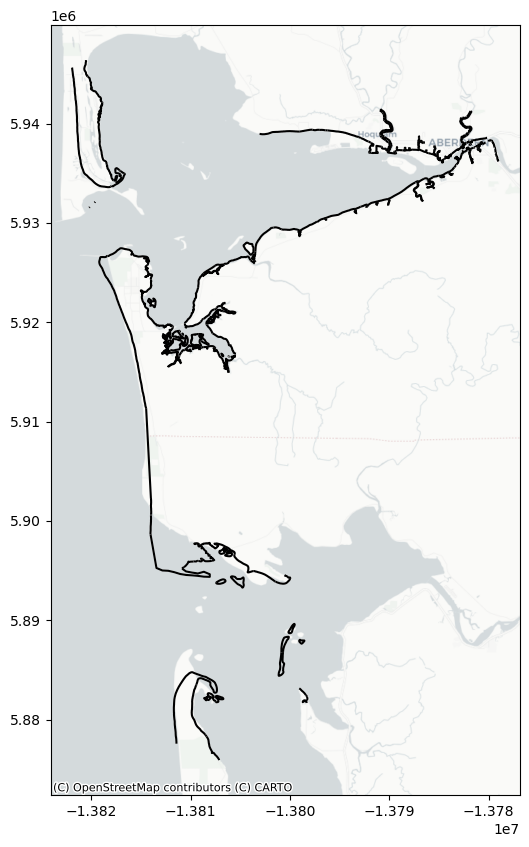

In [824]:
gdf_1920 = gpd.read_file('assets/ECY_estimated_shorelines/Aug21/1920.geojson')

# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)

gdf_1920 = gdf_1920.to_crs(epsg=3857)

# assuming gdf1 and gdf2 are your GeoDataFrames
fig, ax = plt.subplots(figsize = (10,10))

# plot the base map
base = gdf_1920.plot(ax=ax, color='white', edgecolor='black')

gdf_1920.plot(ax=base, marker='o', color='black', markersize=5)


# plot the first GeoDataFrame
#gdf_1922.plot(ax=base, marker='o', color='red', markersize=5)

# plot the second GeoDataFrame
#gdf_1926.plot(ax=base, marker='o', color='blue', markersize=5)

#gdf_1926_ecy.plot(ax=base, marker='o', color='green', markersize=5)

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

In [731]:
gdf_1926

,id,YEAR,MONTH,Shape_Leng,geometry
0,0,1926,8,579.295047,"LINESTRING (-124.09337 46.89019, -124.09343 46..."
1,1,1926,8,762.883965,"LINESTRING (-124.13219 46.90506, -124.14213 46..."
2,2,1926,8,188.089538,"LINESTRING (-124.09949 46.90245, -124.09957 46..."
3,3,1927,5,31.339770,"LINESTRING (-124.13190 46.94653, -124.13151 46..."
4,4,1927,5,34.981365,"LINESTRING (-124.15003 46.93395, -124.15049 46..."
5,5,1927,5,35.974010,"LINESTRING (-124.15314 46.93225, -124.15267 46..."
6,6,0,0,51.323861,"LINESTRING (-124.16932 47.11741, -124.16891 47..."
7,7,1926,7,75.956163,"LINESTRING (-124.09085 46.26283, -124.09074 46..."
8,8,1926,7,4699.401439,"LINESTRING (-124.05420 46.27376, -124.05385 46..."
9,9,1926,7,381.501349,"LINESTRING (-124.00894 46.26679, -124.00803 46..."


# plot the line from 1926 to 1942

In [615]:
#import the 1942 shoreline from WA ECY
gdf_1942_ecy = gpd.read_file('assets/ECY_historical_shorelines_epsg32149/1942.geojson')
gdf_1942_ecy=gdf_1942_ecy.cx[minx:maxx, miny:maxy]
gdf_1942_ecy

,id,YEAR,MONTH,DAY,PHOTO_,Shape_Leng,geometry
0,0,1942,7,0,gra_md,899.055501,"LINESTRING (-124.14352 46.90580, -124.13174 46..."
1,1,1942,7,0,gra_md,2703.027041,"LINESTRING (-124.16218 46.90646, -124.16522 46..."
2,2,1942,7,0,gra_md,1401.059107,"LINESTRING (-124.16178 46.90614, -124.15910 46..."
3,3,1942,7,0,gra_md,1201.276320,"LINESTRING (-124.13082 46.89460, -124.13159 46..."
4,4,1942,7,0,gra_md,602.662308,"LINESTRING (-124.14342 46.90544, -124.13552 46..."
5,5,1942,7,0,gra_md,108.441114,"LINESTRING (-124.13552 46.90521, -124.13411 46..."
6,6,1942,7,0,gra_md,933.918226,"LINESTRING (-124.11188 46.84856, -124.11213 46..."
7,7,1942,7,0,gra_md,1195.004106,"LINESTRING (-124.13082 46.89460, -124.13035 46..."
8,8,1942,7,0,grymod,832.930001,"LINESTRING (-124.09413 46.75008, -124.09414 46..."
9,9,1942,7,0,grymod,1884.092087,"LINESTRING (-124.09426 46.73682, -124.09427 46..."


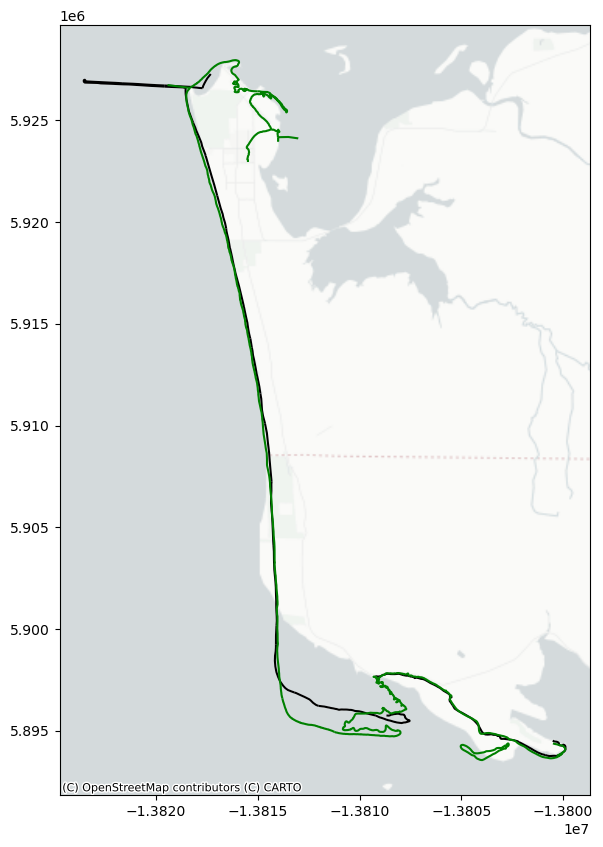

In [591]:
# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)

gdf_1942_ecy = gdf_1942_ecy.to_crs(epsg=3857)

# assuming gdf1 and gdf2 are your GeoDataFrames
fig, ax = plt.subplots(figsize = (10,10))

# plot the base map
base = gdf_1942_ecy.plot(ax=ax, color='white', edgecolor='black')

gdf_1942_ecy.plot(ax=base, marker='o', color='black', markersize=5)


# plot the first GeoDataFrame
#gdf_1922.plot(ax=base, marker='o', color='red', markersize=5)

# plot the second GeoDataFrame
#gdf_1926.plot(ax=base, marker='o', color='blue', markersize=5)

gdf_1926_ecy.plot(ax=base, marker='o', color='green', markersize=5)

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

# plot the shoreline from 1942 to 1954

In [610]:
#import the 1954 shoreline from WA ECY
gdf_1954_ecy = gpd.read_file('assets/ECY_historical_shorelines_epsg32149/1954.geojson')
gdf_1954_ecy=gdf_1954_ecy.cx[minx:maxx, miny:maxy]
gdf_1954_ecy

,id,YEAR,MONTH,Shape_Leng,geometry
9,9,1951,6,33.469891,"LINESTRING (-124.11675 46.91241, -124.11660 46..."
10,10,1950,0,3809.589625,"LINESTRING (-124.03064 46.71436, -124.03071 46..."
12,12,1950,6,512.111785,"LINESTRING (-124.00129 46.70653, -124.00090 46..."
16,16,1950,0,537.473813,"LINESTRING (-124.00129 46.70643, -124.00133 46..."
17,17,1950,6,9257.288626,"LINESTRING (-123.98289 46.72117, -123.98284 46..."
21,21,1951,6,14079.322633,"LINESTRING (-124.12104 46.87481, -124.11995 46..."
22,22,1951,6,9243.570896,"LINESTRING (-124.12628 46.88650, -124.12641 46..."
23,23,1951,6,1365.650040,"LINESTRING (-124.12629 46.88649, -124.12620 46..."
24,24,1951,6,1196.891450,"LINESTRING (-124.12625 46.90357, -124.12605 46..."
25,25,1951,6,3038.210031,"LINESTRING (-124.11190 46.90853, -124.11181 46..."


In [613]:
#import the 1954 shoreline from NOAA
gdf_1954_noaa = gpd.read_file('assets/f_1954_coastline.geojson')
gdf_1954_noaa=gdf_1954_noaa.cx[minx:maxx, miny:maxy]
gdf_1954_noaa

,FEATURE_ID,FEATURE,SOURCE_ID,DATA_SOURC,SRC_DATE,HOR_ACC,INFORM,RESOLUTION,ATTRIBUTE,CLASS,F_CODE,EX_METH,EXTRACT_TE,geometry
208,733695.0,20.0,T09517S,A,19500701,0,None,0.0,Natural.Mean High Water,SHORELINE,None,S,A,"MULTILINESTRING ((-124.15594 46.90639, -124.15..."
209,733696.0,20.0,T09517S,A,19500701,0,None,0.0,Natural.Mean High Water,SHORELINE,None,S,A,"MULTILINESTRING ((-124.15772 46.90652, -124.15..."
213,733703.0,20.0,T09517S,A,19500701,0,None,0.0,Natural.Mean High Water,SHORELINE,None,S,A,"MULTILINESTRING ((-124.12866 46.90481, -124.12..."
217,733392.0,20.0,T09517S,A,19500701,0,None,0.0,Natural.Mean High Water,SHORELINE,None,S,A,"MULTILINESTRING ((-124.12639 46.88654, -124.12..."
218,733393.0,28.0,T09517S,A,19500701,0,None,0.0,Shoreline/Alongshore Feature Boundary,SHORELINE,None,S,A,"MULTILINESTRING ((-124.13933 46.90550, -124.12..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,732985.0,15.0,T09521,A,19510601,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,S,A,"MULTILINESTRING ((-124.02090 46.87079, -124.02..."
733,732986.0,15.0,T09521,A,19510601,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,S,A,"MULTILINESTRING ((-124.01907 46.87008, -124.01..."
734,732987.0,20.0,T09521,A,19510601,0,None,0.0,Natural.Mean High Water,SHORELINE,None,S,A,"MULTILINESTRING ((-124.01987 46.87096, -124.01..."
735,732988.0,20.0,T09521,A,19510601,0,None,0.0,Natural.Mean High Water,SHORELINE,None,S,A,"MULTILINESTRING ((-124.03223 46.87395, -124.03..."


In [604]:
import pandas as pd
combined_gdf_1954 = pd.concat([gdf_1954_ecy, gdf_1954_noaa])

In [605]:
combined_gdf_1954

,id,YEAR,MONTH,Shape_Leng,geometry,FEATURE_ID,FEATURE,SOURCE_ID,DATA_SOURC,SRC_DATE,HOR_ACC,INFORM,RESOLUTION,ATTRIBUTE,CLASS,F_CODE,EX_METH,EXTRACT_TE
9,9,1951.0,6.0,33.469891,"LINESTRING (-13816613.101 5927788.764, -138165...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,10,1950.0,0.0,3809.589625,"LINESTRING (-13807027.492 5895575.038, -138070...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,12,1950.0,6.0,512.111785,"LINESTRING (-13803760.997 5894302.476, -138037...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,16,1950.0,0.0,537.473813,"LINESTRING (-13803760.156 5894287.597, -138037...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,17,1950.0,6.0,9257.288626,"LINESTRING (-13801711.639 5896679.512, -138017...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-13805943.436 5921009.155, -...",732985.0,15.0,T09521,A,19510601,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,S,A
733,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-13805739.721 5920893.545, -...",732986.0,15.0,T09521,A,19510601,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,S,A
734,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-13805828.777 5921036.836, -...",732987.0,20.0,T09521,A,19510601,0,None,0.0,Natural.Mean High Water,SHORELINE,None,S,A
735,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-13807204.686 5921523.719, -...",732988.0,20.0,T09521,A,19510601,0,None,0.0,Natural.Mean High Water,SHORELINE,None,S,A


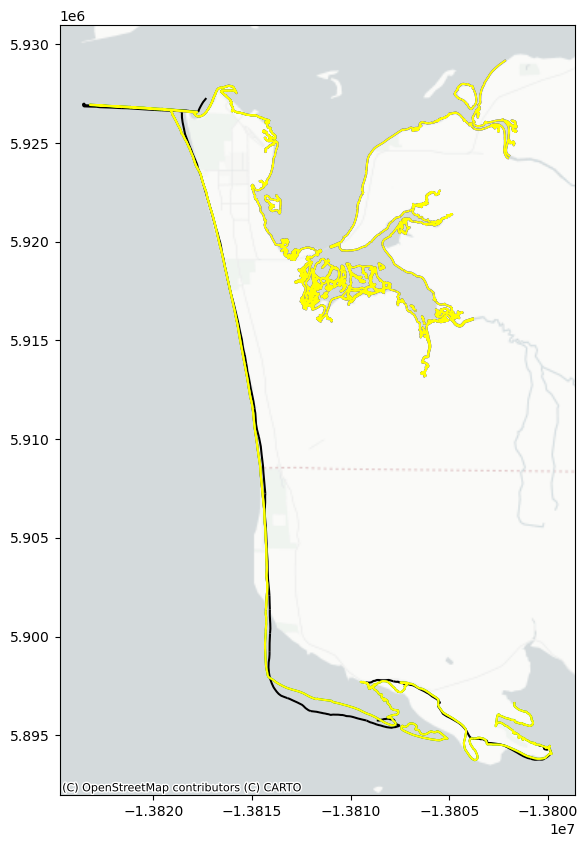

In [606]:
# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)

gdf_1954_ecy = gdf_1954_ecy.to_crs(epsg=3857)
gdf_1954_noaa = gdf_1954_noaa.to_crs(epsg=3857)
combined_gdf_1954 = combined_gdf_1954.to_crs(epsg=3857)

# assuming gdf1 and gdf2 are your GeoDataFrames
fig, ax = plt.subplots(figsize = (10,10))

# plot the base map
base = gdf_1942_ecy.plot(ax=ax, color='white', edgecolor='black')

gdf_1942_ecy.plot(ax=base, marker='o', color='black', markersize=5)


# plot the first GeoDataFrame
#gdf_1922.plot(ax=base, marker='o', color='red', markersize=5)

# plot the second GeoDataFrame
gdf_1954_noaa.plot(ax=base, marker='o', color='blue', markersize=5)

gdf_1954_ecy.plot(ax=base, marker='o', color='green', markersize=5)

combined_gdf_1954.plot(ax=base, marker='o', color='yellow', markersize=5)

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

## get the intersection between the green line and black line around North Cove

In [625]:
gdf_1954_ecy

,id,YEAR,MONTH,Shape_Leng,geometry
9,9,1951,6,33.469891,"LINESTRING (-124.11675 46.91241, -124.11660 46..."
10,10,1950,0,3809.589625,"LINESTRING (-124.03064 46.71436, -124.03071 46..."
12,12,1950,6,512.111785,"LINESTRING (-124.00129 46.70653, -124.00090 46..."
16,16,1950,0,537.473813,"LINESTRING (-124.00129 46.70643, -124.00133 46..."
17,17,1950,6,9257.288626,"LINESTRING (-123.98289 46.72117, -123.98284 46..."
21,21,1951,6,14079.322633,"LINESTRING (-124.12104 46.87481, -124.11995 46..."
22,22,1951,6,9243.570896,"LINESTRING (-124.12628 46.88650, -124.12641 46..."
23,23,1951,6,1365.650040,"LINESTRING (-124.12629 46.88649, -124.12620 46..."
24,24,1951,6,1196.891450,"LINESTRING (-124.12625 46.90357, -124.12605 46..."
25,25,1951,6,3038.210031,"LINESTRING (-124.11190 46.90853, -124.11181 46..."


In [611]:
minx_nc, miny_nc, maxx_nc, maxy_nc = -124.116634, 46.718657, -124.063679, 46.766602  # these are just example coordinates

gdf_1954_ecy_NC=gdf_1954_ecy.cx[minx_nc:maxx_nc, miny_nc:maxy_nc]

gdf_1954_ecy_NC

,id,YEAR,MONTH,Shape_Leng,geometry
21,21,1951,6,14079.322633,"LINESTRING (-124.12104 46.87481, -124.11995 46..."
66,66,1950,0,9261.632933,"LINESTRING (-124.09591 46.74983, -124.09593 46..."


In [616]:
gdf_1942_ecy_NC=gdf_1942_ecy.cx[minx_nc:maxx_nc, miny_nc:maxy_nc]

gdf_1942_ecy_NC

,id,YEAR,MONTH,DAY,PHOTO_,Shape_Leng,geometry
8,8,1942,7,0,grymod,832.930001,"LINESTRING (-124.09413 46.75008, -124.09414 46..."
9,9,1942,7,0,grymod,1884.092087,"LINESTRING (-124.09426 46.73682, -124.09427 46..."
10,10,1942,7,0,grymod,944.477713,"LINESTRING (-124.08619 46.72241, -124.08528 46..."
11,11,1942,7,0,grymod,641.664488,"LINESTRING (-124.09426 46.73682, -124.09423 46..."
29,29,1942,7,0,grymod,1410.072244,"LINESTRING (-124.09535 46.76699, -124.09517 46..."
30,30,1942,7,0,grymod,472.893623,"LINESTRING (-124.09432 46.75433, -124.09423 46..."


In [621]:
import geopandas as gpd
from shapely.geometry import Point

def get_intersection(gdf1, gdf2):


    intersection_list = []

    for index1, row1 in gdf1.iterrows():
        for index2, row2 in gdf2.iterrows():
            # Check if intersection exist
            if row1['geometry'].intersects(row2['geometry']):
                # Get the intersection part
                intersection = row1['geometry'].intersection(row2['geometry'])

                # Check if intersection is a point (it could also be a line)
                if isinstance(intersection, Point):
                    # Append intersection point to a list
                    intersection_list.append(intersection)

    return intersection_list

get_intersection(gdf_1942_ecy_NC, gdf_1954_ecy_NC)


[<POINT (-124.094 46.729)>]

In [624]:
print(get_intersection(gdf_1942_ecy_NC, gdf_1954_ecy_NC)[0].x,get_intersection(gdf_1942_ecy_NC, gdf_1954_ecy_NC)[0].y)

-124.0940776835104 46.72865654243524


In [649]:
left_washaway=[get_intersection(gdf_1942_ecy_NC, gdf_1954_ecy_NC)[0].x,get_intersection(gdf_1942_ecy_NC, gdf_1954_ecy_NC)[0].y]
left_washaway

[-124.0940776835104, 46.72865654243524]

In [641]:
from shapely.geometry import box

/usr/local/Caskroom/miniconda/base/envs/geo/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


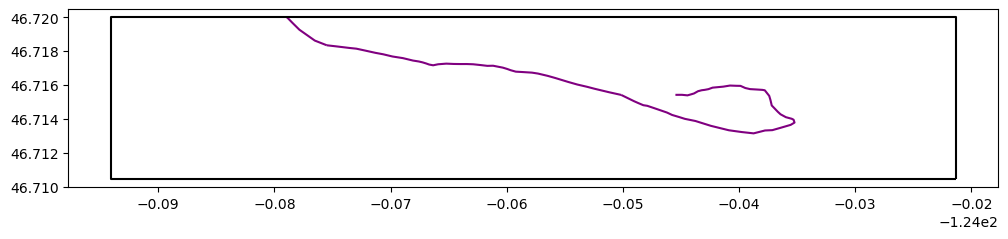

In [644]:
minx_nc_tip, miny_nc_tip, maxx_nc_tip, maxy_nc_tip = -124.0940776835104, 46.710446, -124.021313, 46.72

#bbox=[minx_nc_tip, miny_nc_tip, maxx_nc_tip, maxy_nc_tip]

#bbox_polygon = Polygon([(bbox[0], bbox[1]), (bbox[0], bbox[3]), (bbox[2], bbox[3]), (bbox[2], bbox[1])])

polygon=box(minx_nc_tip, miny_nc_tip, maxx_nc_tip, maxy_nc_tip)
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=gdf_1942_ecy.crs)

gdf_1942_ecy_clipped = gdf_1942_ecy.clip(polygon)

fig, ax = plt.subplots(figsize=(12, 8))
gdf_1942_ecy_clipped.plot(ax=ax, color="purple")
poly_gdf.boundary.plot(ax=ax, color="black")


plt.show()
#bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_polygon], crs=gdf_1954_ecy.crs)

# Clip the original GeoDataFrame to the bounding box
#clipped_gdf = gpd.clip(gdf_1954_ecy, bbox_gdf)

#clipped_gdf
#gdf_1942_ecy.intersection(bbox_polygon)

#gdf_1942_ecy_NC_tip=gdf_1942_ecy.cx[minx_nc_tip:maxx_nc_tip, miny_nc_tip:maxy_nc_tip]

#gdf_1942_ecy_NC_tip

In [646]:
#then find the easternmost point of the above clipped 1942 shoreline

easternmost_lon = None
easternmost_point = None

bbox_polygon=box(minx_nc_tip, miny_nc_tip, maxx_nc_tip, maxy_nc_tip)

for ls in gdf_1942_ecy.intersection(bbox_polygon):
   if isinstance(ls, LineString):
        # Extract points
        points = list(ls.coords)
        for point in points:
            # Compare y coordinate (longitude) with current easternmost latitude
            if easternmost_lon is None or point[0] > easternmost_lon:
                easternmost_lon = point[0]
                easternmost_point = point

print(f'Easternmost point is at longitude {easternmost_lon} and coordinates {easternmost_point}')

Easternmost point is at longitude -124.03522863018114 and coordinates (-124.03522863018114, 46.71377593241277)


In [650]:
right_washaway=[easternmost_point[0],easternmost_point[1]]
right_washaway

[-124.03522863018114, 46.71377593241277]

In [654]:
#now divide the value from left_washaway and right_washaway by 4 

boundaries = np.linspace(left_washaway[0], right_washaway[0], 5)

boundaries

array([-124.09407768, -124.07936542, -124.06465316, -124.04994089,
       -124.03522863])

In [655]:
from itertools import repeat

In [657]:
lat_down = 46.710446


#zip lat_down and boundaries together
# Repeat the single value for the length of the array
repeated_value_down = repeat(lat_down, len(boundaries)-2)

# Zip the array and the repeated single value together
paired_values_down = list(zip(boundaries[1:-1], repeated_value_down))

paired_values_down


[(-124.07936542017809, 46.710446),
 (-124.06465315684576, 46.710446),
 (-124.04994089351345, 46.710446)]

In [658]:
lat_up = 46.73

#zip lat_down and boundaries together
# Repeat the single value for the length of the array
repeated_value_up = repeat(lat_up, len(boundaries)-2)

# Zip the array and the repeated single value together
paired_values_up = list(zip(boundaries[1:-1], repeated_value_up))

paired_values_up

[(-124.07936542017809, 46.73),
 (-124.06465315684576, 46.73),
 (-124.04994089351345, 46.73)]

In [659]:
#now zip the paired_values_down and paired_values_up together, and create a list of linestring
lines = [LineString(pair) for pair in zip(paired_values_down, paired_values_up)]

lines


[<LINESTRING (-124.079 46.71, -124.079 46.73)>,
 <LINESTRING (-124.065 46.71, -124.065 46.73)>,
 <LINESTRING (-124.05 46.71, -124.05 46.73)>]

In [667]:
#find the intersection of the transects and the 1942 shoreline
intersection_1942_transects={}
for i,line in enumerate(lines):
    intersections_1942 = gdf_1942_ecy.geometry.apply(lambda x: line.intersection(x))
    intersections_1942=intersections_1942[~intersections_1942.is_empty]
    intersection_1942_transects[str(i)]=intersections_1942

intersection_1942_transects

{'0': 10    POINT (-124.07937 46.72024)
 Name: geometry, dtype: geometry,
 '1': 12    POINT (-124.06465 46.71724)
 Name: geometry, dtype: geometry,
 '2': 13    POINT (-124.04994 46.71534)
 16    POINT (-124.04994 46.72728)
 Name: geometry, dtype: geometry}

In [694]:
intersection_1942_transects["2"].drop(16, inplace=True)

In [695]:
intersection_1942_transects["2"]

13    POINT (-124.04994 46.71534)
Name: geometry, dtype: geometry

In [696]:
intersection_1942_transects

{'0': 10    POINT (-124.07937 46.72024)
 Name: geometry, dtype: geometry,
 '1': 12    POINT (-124.06465 46.71724)
 Name: geometry, dtype: geometry,
 '2': 13    POINT (-124.04994 46.71534)
 Name: geometry, dtype: geometry}

In [668]:
#find the intersection of the transects and the 1954 shoreline
intersection_1954_transects={}
for i,line in enumerate(lines):
    intersections_1954 = gdf_1954_ecy.geometry.apply(lambda x: line.intersection(x))
    intersections_1954=intersections_1954[~intersections_1954.is_empty]
    intersection_1954_transects[str(i)]=intersections_1954

intersection_1954_transects

{'0': 66    POINT (-124.07937 46.72405)
 Name: geometry, dtype: geometry,
 '1': 66    POINT (-124.06465 46.72104)
 Name: geometry, dtype: geometry,
 '2': 66                          POINT (-124.04994 46.71758)
 67    MULTIPOINT (-124.04994 46.72706, -124.04994 46...
 Name: geometry, dtype: geometry}

In [697]:
intersection_1954_transects["2"].drop(67, inplace=True)

In [698]:
intersection_1954_transects

{'0': 66    POINT (-124.07937 46.72405)
 Name: geometry, dtype: geometry,
 '1': 66    POINT (-124.06465 46.72104)
 Name: geometry, dtype: geometry,
 '2': 66    POINT (-124.04994 46.71758)
 Name: geometry, dtype: geometry}

In [707]:
trans={}
trans["0"]=LineString([intersection_1942_transects["0"].iloc[0], intersection_1954_transects["0"].iloc[0]])
trans["1"]=LineString([intersection_1942_transects["1"].iloc[0], intersection_1954_transects["1"].iloc[0]])
trans["2"]=LineString([intersection_1942_transects["2"].iloc[0], intersection_1954_transects["2"].iloc[0]])


In [708]:
trans

{'0': <LINESTRING (-124.079 46.72, -124.079 46.724)>,
 '1': <LINESTRING (-124.065 46.717, -124.065 46.721)>,
 '2': <LINESTRING (-124.05 46.715, -124.05 46.718)>}

In [716]:
def divide_line_into_points(line, segments):
    return [line.interpolate(i/segments, normalized=True) for i in range(1, segments)]

divide_line_into_points(trans["0"], 12)



[<POINT (-124.079 46.721)>,
 <POINT (-124.079 46.721)>,
 <POINT (-124.079 46.721)>,
 <POINT (-124.079 46.722)>,
 <POINT (-124.079 46.722)>,
 <POINT (-124.079 46.722)>,
 <POINT (-124.079 46.722)>,
 <POINT (-124.079 46.723)>,
 <POINT (-124.079 46.723)>,
 <POINT (-124.079 46.723)>,
 <POINT (-124.079 46.724)>]

In [717]:
interpolated_1942_1954={}
for y in range (1943,1954):
    print(y)
    interpolated_1942_1954[str(y)]=LineString([divide_line_into_points(trans["0"], 12)[y-1943],divide_line_into_points(trans["1"], 12)[y-1943],divide_line_into_points(trans["2"], 12)[y-1943]])

interpolated_1942_1954



1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953


{'1943': <LINESTRING (-124.079 46.721, -124.065 46.718, -124.05 46.716)>,
 '1944': <LINESTRING (-124.079 46.721, -124.065 46.718, -124.05 46.716)>,
 '1945': <LINESTRING (-124.079 46.721, -124.065 46.718, -124.05 46.716)>,
 '1946': <LINESTRING (-124.079 46.722, -124.065 46.719, -124.05 46.716)>,
 '1947': <LINESTRING (-124.079 46.722, -124.065 46.719, -124.05 46.716)>,
 '1948': <LINESTRING (-124.079 46.722, -124.065 46.719, -124.05 46.716)>,
 '1949': <LINESTRING (-124.079 46.722, -124.065 46.719, -124.05 46.717)>,
 '1950': <LINESTRING (-124.079 46.723, -124.065 46.72, -124.05 46.717)>,
 '1951': <LINESTRING (-124.079 46.723, -124.065 46.72, -124.05 46.717)>,
 '1952': <LINESTRING (-124.079 46.723, -124.065 46.72, -124.05 46.717)>,
 '1953': <LINESTRING (-124.079 46.724, -124.065 46.721, -124.05 46.717)>}

In [692]:
print(intersection_1954_transects["2"].iloc[0])
#get the first point of the intersection of the 1954 shoreline and the transects


POINT (-124.04994089351345 46.717575589725165)


## the bay side is not plotted in WA ECY dataset, but it is plotted in NOAA dataset. So we will plot the NOAA 2006 dataset to see how the coastline on the bay changed.

In [599]:
gdf_2006_noaa = gpd.read_file('assets/f_2006_coastline.geojson')
gdf_2006_noaa=gdf_2006_noaa.cx[minx:maxx, miny:maxy]
gdf_2006_noaa

,FEATURE_ID,FEATURE,SOURCE_ID,DATA_SOURC,SRC_DATE,HOR_ACC,INFORM,RESOLUTION,ATTRIBUTE,CLASS,EXT_METH,EXTRACT_TE,geometry
1,14371.0,15.0,GC10746,D,20060423,1.2,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,S,S,"MULTILINESTRING ((-124.07159 46.84838, -124.07..."
2,14368.0,15.0,GC10746,D,20060423,1.2,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,S,S,"MULTILINESTRING ((-124.08672 46.86335, -124.08..."
3,14369.0,15.0,GC10746,D,20060423,1.2,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,S,S,"MULTILINESTRING ((-124.08656 46.86366, -124.08..."
4,14370.0,15.0,GC10746,D,20060423,1.2,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,S,S,"MULTILINESTRING ((-124.07308 46.84995, -124.07..."
5,14372.0,15.0,GC10746,D,20060423,1.2,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,S,S,"MULTILINESTRING ((-124.05797 46.85020, -124.05..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,731789.0,15.0,GC10746,D,20060423,1.2,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,S,S,"MULTILINESTRING ((-124.07154 46.84592, -124.07..."
1395,731790.0,15.0,GC10746,D,20060423,1.2,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,S,S,"MULTILINESTRING ((-124.07279 46.85381, -124.07..."
1396,731791.0,15.0,GC10746,D,20060423,1.2,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,S,S,"MULTILINESTRING ((-124.07727 46.85452, -124.07..."
1407,731802.0,10.0,GC10746,D,20060423,1.2,None,0.0,Man-made.Rip Rap,SHORELINE,S,S,"MULTILINESTRING ((-124.11453 46.91257, -124.11..."


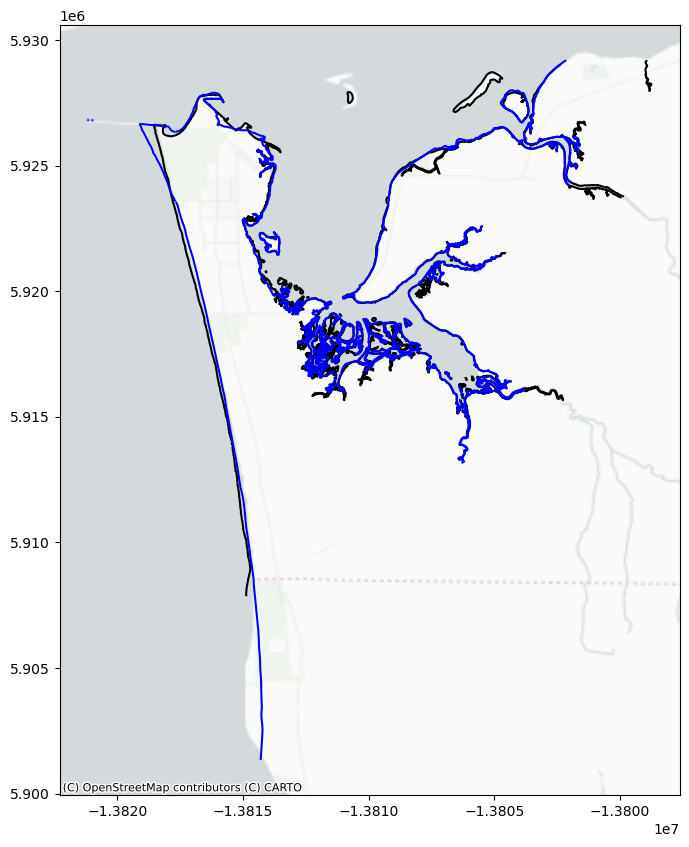

In [600]:

gdf_2006_noaa = gdf_2006_noaa.to_crs(epsg=3857)

# assuming gdf1 and gdf2 are your GeoDataFrames
fig, ax = plt.subplots(figsize = (10,10))

# plot the base map
base = gdf_1954_noaa.plot(ax=ax, color='white', edgecolor='black')

gdf_2006_noaa.plot(ax=base, marker='o', color='black', markersize=5)


# plot the first GeoDataFrame
#gdf_1922.plot(ax=base, marker='o', color='red', markersize=5)

# plot the second GeoDataFrame
gdf_1954_noaa.plot(ax=base, marker='o', color='blue', markersize=5)

#gdf_1954_ecy.plot(ax=base, marker='o', color='green', markersize=5)

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

# plot the shoreline from 1954 to 1967

In [569]:
#import the 1954 shoreline from WA ECY
gdf_1967_ecy = gpd.read_file('assets/ECY_historical_shorelines_epsg32149/1967.geojson')
gdf_1967_ecy

,id,YEAR,MONTH,DAY,PHOTO,Shape_Leng,geometry
0,0,1967,4,15,grn_1967.img,117.371797,"LINESTRING (-124.27733 47.30378, -124.27728 47..."
1,1,1967,4,15,grn_1967.img,312.459155,"LINESTRING (-124.23185 47.27833, -124.23177 47..."
2,2,1967,4,15,grn_1967.img,475.159016,"LINESTRING (-124.23073 47.27563, -124.23060 47..."
3,3,1967,4,15,grn_1967.img,297.470237,"LINESTRING (-124.27982 47.31068, -124.27977 47..."
4,4,1967,4,15,grn_1967.img,115.924494,"LINESTRING (-124.27805 47.30759, -124.27800 47..."
...,...,...,...,...,...,...,...
359,359,1963,8,8,shoalw_1963mos.img,1370.493486,"LINESTRING (-124.05122 46.72089, -124.05092 46..."
360,360,1963,8,8,shoalw_1963mos.img,1827.668596,"LINESTRING (-124.03547 46.71507, -124.03458 46..."
361,361,1963,8,8,shoalw_1963mos.sid,798.095156,"LINESTRING (-124.01726 46.70811, -124.01761 46..."
362,362,1963,8,8,shoalw_1963mos.sid,1662.140942,"LINESTRING (-124.02647 46.71145, -124.02684 46..."


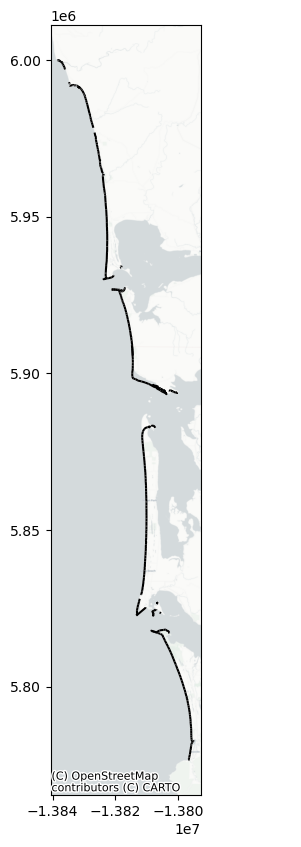

In [573]:
# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)

gdf_1967_ecy = gdf_1967_ecy.to_crs(epsg=3857)

# assuming gdf1 and gdf2 are your GeoDataFrames
fig, ax = plt.subplots(figsize = (10,10))

# plot the base map
base = gdf_1967_ecy.plot(ax=ax, color='white', edgecolor='black')

gdf_1967_ecy.plot(ax=base, marker='o', color='black', markersize=5)


# plot the first GeoDataFrame
#gdf_1922.plot(ax=base, marker='o', color='red', markersize=5)

# plot the second GeoDataFrame
#gdf_1926.plot(ax=base, marker='o', color='blue', markersize=5)

#gdf_1954_ecy.plot(ax=base, marker='o', color='green', markersize=5)

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

# Plot the area of south beach (ocosta school district)

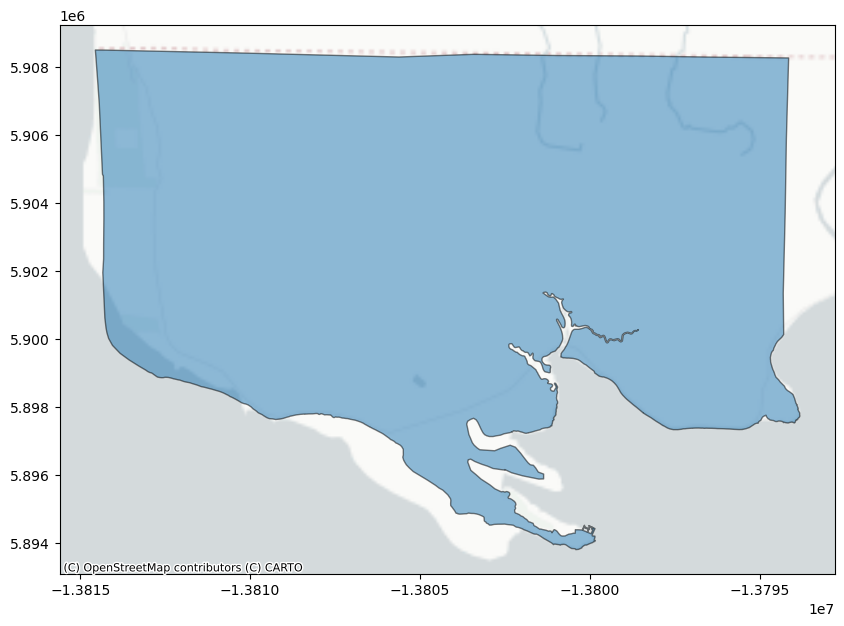

In [388]:
gdf = gpd.read_file("assets/shapefile/School_Districts_2010.shp")

gdf=gdf[gdf['SCHOOL_NAM']=='Ocosta']

# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)
gdf = gdf.to_crs(epsg=3857)

# Create a plot
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()

In [402]:
gdf = gpd.read_file("assets/shapefile/School_Districts_2010.shp")

gdf = gdf.to_crs(epsg=3857)

gdf=gdf[gdf['SCHOOL_NAM']=='Ocosta']

# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)


In [403]:
# Rename columns
gdf = gdf.rename(columns={
   'SCHOOL_NAM': 'NAME',
   
})


In [404]:

gdf.drop(columns=['Sq_Miles'],inplace=True)

In [405]:
gdf

,NAME,geometry
3,Ocosta,"POLYGON ((-13794269.328 5903730.307, -13794326..."


In [406]:
gdf_1 = gpd.read_file("assets/shapefile/School_Districts.shp")

gdf_1 = gdf_1.to_crs(epsg=3857)


In [407]:
gdf_1

,DIRECTOR,NAME,geometry
0,9,Taholah,"POLYGON ((-13842934.249 6029600.898, -13840803..."
1,3,Wishkah Valley,"POLYGON ((-13781002.737 5998508.208, -13781091..."
2,4,Wishkah Valley,"POLYGON ((-13778632.930 5998494.814, -13776361..."
3,5,Wishkah Valley,"POLYGON ((-13776361.734 5998528.988, -13775482..."
4,9,Mary M. Knight,"POLYGON ((-13748547.281 5996000.582, -13748580..."
5,1,North Beach,"POLYGON ((-13808733.813 5983315.796, -13808738..."
6,5,Montesano,"POLYGON ((-13769595.460 5984037.887, -13769036..."
7,9,Hoquiam,"MULTIPOLYGON (((-13787936.282 5935172.898, -13..."
8,2,Wishkah Valley,"POLYGON ((-13785708.318 5959991.975, -13783405..."
9,1,Wishkah Valley,"POLYGON ((-13781096.210 5958086.069, -13778021..."


In [408]:


gdf_1=gdf_1[gdf_1['NAME']=='Ocosta']
gdf_1.drop(columns=['DIRECTOR'],inplace=True)

/var/folders/33/68l3prl56lsc37gr_prx3v_00000gn/T/ipykernel_67267/236308770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_1.drop(columns=['DIRECTOR'],inplace=True)


In [409]:
gdf_1

,NAME,geometry
25,Ocosta,"MULTIPOLYGON (((-13813916.861 5924200.916, -13..."
26,Ocosta,"MULTIPOLYGON (((-13818056.498 5926580.158, -13..."
30,Ocosta,"POLYGON ((-13812746.029 5919086.725, -13812745..."
43,Ocosta,"POLYGON ((-13811584.411 5919540.822, -13811519..."


In [410]:
result=gdf.append(gdf_1)
result

/var/folders/33/68l3prl56lsc37gr_prx3v_00000gn/T/ipykernel_67267/1246754854.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result=gdf.append(gdf_1)


,NAME,geometry
3,Ocosta,"POLYGON ((-13794269.328 5903730.307, -13794326..."
25,Ocosta,"MULTIPOLYGON (((-13813916.861 5924200.916, -13..."
26,Ocosta,"MULTIPOLYGON (((-13818056.498 5926580.158, -13..."
30,Ocosta,"POLYGON ((-13812746.029 5919086.725, -13812745..."
43,Ocosta,"POLYGON ((-13811584.411 5919540.822, -13811519..."


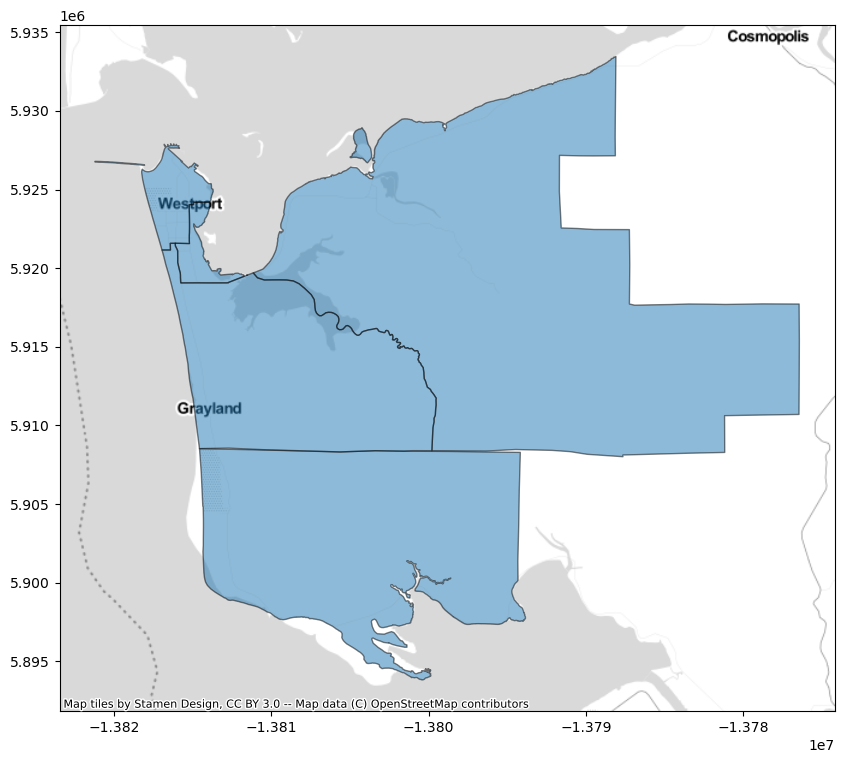

In [413]:
# Create a plot
ax = result.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.Stamen.TonerLite)

# Show the plot
plt.show()

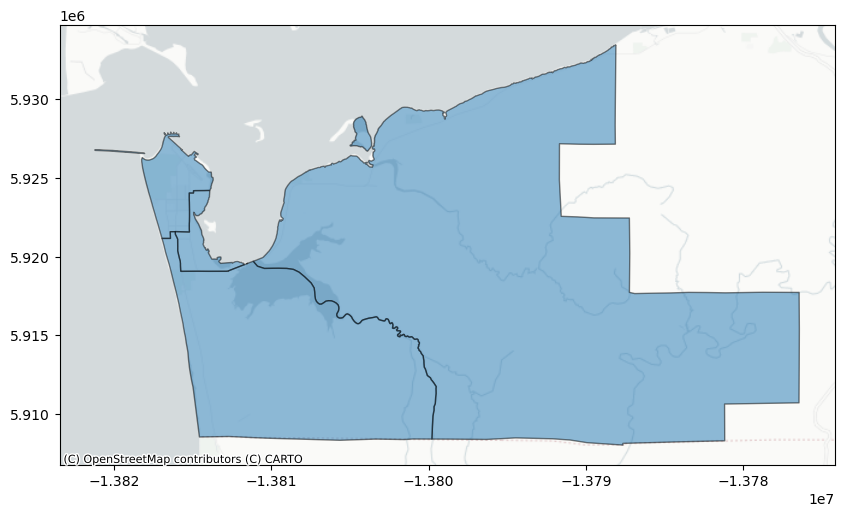

In [384]:
gdf = gpd.read_file("assets/shapefile/School_Districts.shp")

gdf=gdf[gdf['NAME']=='Ocosta']

# Make sure the GeoDataFrame uses the Web Mercator projection (EPSG 3857)
gdf = gdf.to_crs(epsg=3857)

# Create a plot
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add a basemap
ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

# Show the plot
plt.show()


In [ ]:
#point = [lon,lat]
def convert_pt_cooridination_system_to_wgs(point):
    # Define the source and target coordinate systems
    src_crs = pyproj.CRS.from_epsg(32149)
    tgt_crs = pyproj.CRS.from_epsg(4326)

    # Create a transformer object
    transformer = pyproj.Transformer.from_crs(src_crs, tgt_crs, always_xy=True)
   
    # Convert a single point
    x_1, y_1 = transformer.transform(point[0], point[1])
        

    return [x_1,y_1]

In [382]:
gdf

,DIRECTOR,NAME,geometry
0,9,Taholah,"POLYGON ((688886.345 825636.563, 693610.171 82..."
1,3,Wishkah Valley,"POLYGON ((823306.507 750557.783, 822868.519 74..."
2,4,Wishkah Valley,"POLYGON ((828578.471 750308.250, 833635.436 75..."
3,5,Wishkah Valley,"POLYGON ((833635.436 750174.718, 835594.740 75..."
4,9,Mary M. Knight,"POLYGON ((895317.961 742106.733, 895036.966 73..."
5,1,North Beach,"POLYGON ((760087.811 719510.527, 759958.786 71..."
6,5,Montesano,"POLYGON ((847388.243 717385.520, 848636.995 71..."
7,9,Hoquiam,"MULTIPOLYGON (((801870.445 610215.038, 801684...."
8,2,Wishkah Valley,"POLYGON ((809209.103 665374.626, 814351.548 66..."
9,1,Wishkah Valley,"POLYGON ((819338.926 660694.023, 826209.211 66..."
